In [114]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple
import shap

import xgboost as xgb
import catboost as cb

from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, r2_score, classification_report
from sklearn.pipeline import Pipeline


In [115]:
data = pd.read_csv("train_n.csv")
test = pd.read_csv("test_n.csv")

print("train size: {}, {}".format(*data.shape))
print("test size: {}, {}".format(*test.shape))

train size: 40994, 16
test size: 61429, 15


In [116]:
data.columns = data.columns.str.lower()
test.columns = test.columns.str.lower()

In [117]:
print(len(list(data["target"][data['target'] == 1])), data.shape)
print("процентов 1: {}".format(len(list(data["target"][data['target'] == 1]))/ data.shape[0] * 100))

3343 (40994, 16)
процентов 1: 8.154851929550667


In [118]:
print(len(list(data["target"][data['target'] == 0])), data.shape)
print("процентов 0: {}".format(len(list(data["target"][data['target'] == 0]))/ data.shape[0] * 100))

37651 (40994, 16)
процентов 0: 91.84514807044934


In [119]:
data.head(2)

,target,ts_fs_au,application_number,total_salary_family_size,amt_credit_sum_debt_klaster,count_credit,family_married,count_activ_credit,name_contract_type,check_close_credit,bad_pay,long_job,ts_fs_au,count_currancy,age,bad_debt
0,0,0.63200,123526683,67500.0,2.666667,2.0,1.0,2.0,0.05,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,1,0.25525,123710391,90000.0,0.000000,3.0,1.0,1.0,0.05,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [120]:
df = data[data["target"] == 1]

In [121]:
df.shape

(3343, 16)

In [122]:
data = data.append(df, ignore_index = True )

In [123]:
data = data.append(df, ignore_index = True )

In [124]:
data.target.value_counts()

0    37651
1    10029
Name: target, dtype: int64

## разобьем данные

In [125]:
data.columns

Index(['target', 'ts_fs_au', 'application_number', 'total_salary_family_size',
       'amt_credit_sum_debt_klaster', 'count_credit', 'family_married',
       'count_activ_credit', 'name_contract_type', 'check_close_credit',
       'bad_pay', 'long_job', 'ts_fs_au', 'count_currancy', 'age', 'bad_debt'],
      dtype='object')

In [126]:
data = data.drop('ts_fs_au', axis=1)
test = test.drop('ts_fs_au', axis=1)

In [127]:
data.columns = [i.lower() for i in data.columns]
test.columns = [i.lower() for i in test.columns]

In [128]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,
                         ):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    print(X.shape, len(y))
    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")
    print(classification_report(y, oof_predictions))
    

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [129]:
def train_models( train: pd.DataFrame, target: pd.Series, model1 = False ):
    cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}
    if model1:
        model = model1
        
    else:
        model = cb.CatBoostClassifier(**cb_params)
        
    cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

    estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model, metric=roc_auc_score, cv_strategy=cv_strategy
    )
#     return model
    
    explainer = shap.Explainer(model)
    shap_values = explainer(train)
    shap.plots.bar(shap_values)
#     explainer = shap.Explainer(model)
#     shap.plots.bar(shap_values)

In [130]:
def pipeline_train(data: pd.DataFrame, model = False):
    mask = data["target"].isnull()
    features_to_drop = ["application_number", "target"]

    train, test = data.loc[~mask], data.loc[mask]

    target, test_id = train["target"], test["application_number"]
    train = train.drop(features_to_drop, axis=1)
    test = test.drop(features_to_drop, axis=1)
#     categorial = train.dtypes[train.dtypes == "object"].index
#     numerical = list(set(train.columns) - set(categorial))

    train = train.replace(np.inf, np.nan)
    train = train.replace(-np.inf, np.nan)
#     print(train.columns)
    if model:
        train_models(train, target, model)
    else:
        train_models(train, target)
#     return train, test, target, test_id

In [131]:
def train_split(data: pd.DataFrame, RATIO = 0.2):
    
    data = data.sample(frac=RATIO, random_state=27)

    x_train, x_valid = train_test_split(
        data.drop(["application_number", "target"], axis=1), train_size=0.7, random_state=27
    )
    y_train, y_valid = train_test_split(
        data["target"], train_size=0.7, random_state=27
    )
    return x_train, x_valid, y_train, y_valid

In [132]:
RATIO = 0.2
data = data.sample(frac=RATIO, random_state=27)

x_train, x_valid = train_test_split(
    data.drop(["application_number", "target"], axis=1), train_size=0.7, random_state=27
)
y_train, y_valid = train_test_split(
    data["target"], train_size=0.7, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 6675 rows, 12 cols
x_valid.shape = 2861 rows, 12 cols


In [133]:
print(len(test.columns))
print(len(set(test.columns)))
test.columns

13
13


Index(['application_number', 'total_salary_family_size',
       'amt_credit_sum_debt_klaster', 'count_credit', 'family_married',
       'count_activ_credit', 'name_contract_type', 'check_close_credit',
       'bad_pay', 'long_job', 'count_currancy', 'age', 'bad_debt'],
      dtype='object')

In [134]:
print(len(x_train.columns))
print(len(set(x_train.columns)))
x_train.columns

12
12


Index(['total_salary_family_size', 'amt_credit_sum_debt_klaster',
       'count_credit', 'family_married', 'count_activ_credit',
       'name_contract_type', 'check_close_credit', 'bad_pay', 'long_job',
       'count_currancy', 'age', 'bad_debt'],
      dtype='object')

# Base Line

In [135]:
model = xgb.XGBClassifier(random_state=1,
                         n_estimators=100,
                         learning_rate= 0.01,
                         max_depth=20,
#                         early_stopping_rounds=True
                        )
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [136]:
train_score = r2_score(y_train, model.predict(x_train))
test_score = r2_score(y_valid, model.predict(x_valid))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.131, Test-score: -0.325


In [137]:
train_score = roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_valid, model.predict(x_valid))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.67, Test-score: 0.538


# Bootstrap

In [138]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [139]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_valid, model.predict(x_valid), roc_auc_score)

calculate_confidence_interval(scores)

(0.5242330671669346, 0.551832634801194)

# KFOLD

In [140]:
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [141]:
model_cb = cb.CatBoostClassifier()

In [142]:
model_cb = cb.CatBoostClassifier()
cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model_cb, metric=roc_auc_score, cv_strategy=cv_strategy
)

(9536, 12) 9536
Learning rate set to 0.024531
0:	learn: 0.6840743	total: 7.82ms	remaining: 7.81s
1:	learn: 0.6753292	total: 16.8ms	remaining: 8.37s
2:	learn: 0.6670554	total: 22.1ms	remaining: 7.36s
3:	learn: 0.6593862	total: 26.3ms	remaining: 6.55s
4:	learn: 0.6518969	total: 30.9ms	remaining: 6.15s
5:	learn: 0.6449101	total: 35.5ms	remaining: 5.89s
6:	learn: 0.6382444	total: 39.7ms	remaining: 5.63s
7:	learn: 0.6320049	total: 43.9ms	remaining: 5.44s
8:	learn: 0.6260239	total: 48.5ms	remaining: 5.34s
9:	learn: 0.6197454	total: 53.2ms	remaining: 5.27s
10:	learn: 0.6143278	total: 58.1ms	remaining: 5.22s
11:	learn: 0.6091896	total: 62.7ms	remaining: 5.16s
12:	learn: 0.6041890	total: 67.6ms	remaining: 5.13s
13:	learn: 0.5993691	total: 72.3ms	remaining: 5.09s
14:	learn: 0.5950846	total: 76.4ms	remaining: 5.02s
15:	learn: 0.5909505	total: 81ms	remaining: 4.98s
16:	learn: 0.5870765	total: 85.4ms	remaining: 4.94s
17:	learn: 0.5834503	total: 90ms	remaining: 4.91s
18:	learn: 0.5797481	total: 94.7

198:	learn: 0.4966147	total: 875ms	remaining: 3.52s
199:	learn: 0.4965166	total: 880ms	remaining: 3.52s
200:	learn: 0.4964401	total: 884ms	remaining: 3.51s
201:	learn: 0.4964044	total: 888ms	remaining: 3.51s
202:	learn: 0.4963217	total: 892ms	remaining: 3.5s
203:	learn: 0.4961869	total: 896ms	remaining: 3.5s
204:	learn: 0.4960946	total: 901ms	remaining: 3.49s
205:	learn: 0.4959956	total: 905ms	remaining: 3.49s
206:	learn: 0.4959119	total: 909ms	remaining: 3.48s
207:	learn: 0.4958487	total: 914ms	remaining: 3.48s
208:	learn: 0.4957409	total: 918ms	remaining: 3.47s
209:	learn: 0.4956488	total: 922ms	remaining: 3.47s
210:	learn: 0.4955958	total: 926ms	remaining: 3.46s
211:	learn: 0.4955401	total: 931ms	remaining: 3.46s
212:	learn: 0.4954886	total: 935ms	remaining: 3.45s
213:	learn: 0.4952805	total: 939ms	remaining: 3.45s
214:	learn: 0.4951975	total: 943ms	remaining: 3.44s
215:	learn: 0.4951473	total: 948ms	remaining: 3.44s
216:	learn: 0.4950866	total: 952ms	remaining: 3.43s
217:	learn: 0.

366:	learn: 0.4836056	total: 1.59s	remaining: 2.75s
367:	learn: 0.4835293	total: 1.59s	remaining: 2.74s
368:	learn: 0.4834876	total: 1.6s	remaining: 2.74s
369:	learn: 0.4834076	total: 1.6s	remaining: 2.73s
370:	learn: 0.4833533	total: 1.61s	remaining: 2.73s
371:	learn: 0.4832909	total: 1.61s	remaining: 2.72s
372:	learn: 0.4832235	total: 1.62s	remaining: 2.72s
373:	learn: 0.4831554	total: 1.62s	remaining: 2.71s
374:	learn: 0.4830514	total: 1.63s	remaining: 2.71s
375:	learn: 0.4828640	total: 1.63s	remaining: 2.71s
376:	learn: 0.4827471	total: 1.63s	remaining: 2.7s
377:	learn: 0.4826548	total: 1.64s	remaining: 2.7s
378:	learn: 0.4826044	total: 1.64s	remaining: 2.69s
379:	learn: 0.4825429	total: 1.65s	remaining: 2.69s
380:	learn: 0.4824740	total: 1.65s	remaining: 2.68s
381:	learn: 0.4823762	total: 1.66s	remaining: 2.68s
382:	learn: 0.4822865	total: 1.66s	remaining: 2.67s
383:	learn: 0.4821719	total: 1.66s	remaining: 2.67s
384:	learn: 0.4820895	total: 1.67s	remaining: 2.67s
385:	learn: 0.48

535:	learn: 0.4685190	total: 2.31s	remaining: 2s
536:	learn: 0.4683900	total: 2.31s	remaining: 2s
537:	learn: 0.4683311	total: 2.32s	remaining: 1.99s
538:	learn: 0.4682827	total: 2.32s	remaining: 1.99s
539:	learn: 0.4682714	total: 2.33s	remaining: 1.98s
540:	learn: 0.4682181	total: 2.33s	remaining: 1.98s
541:	learn: 0.4682007	total: 2.34s	remaining: 1.97s
542:	learn: 0.4681457	total: 2.34s	remaining: 1.97s
543:	learn: 0.4680463	total: 2.35s	remaining: 1.97s
544:	learn: 0.4679253	total: 2.35s	remaining: 1.96s
545:	learn: 0.4677541	total: 2.35s	remaining: 1.96s
546:	learn: 0.4677012	total: 2.36s	remaining: 1.95s
547:	learn: 0.4676134	total: 2.36s	remaining: 1.95s
548:	learn: 0.4675382	total: 2.37s	remaining: 1.94s
549:	learn: 0.4674480	total: 2.37s	remaining: 1.94s
550:	learn: 0.4673883	total: 2.38s	remaining: 1.94s
551:	learn: 0.4672868	total: 2.38s	remaining: 1.93s
552:	learn: 0.4671615	total: 2.38s	remaining: 1.93s
553:	learn: 0.4670335	total: 2.39s	remaining: 1.92s
554:	learn: 0.4669

702:	learn: 0.4564319	total: 3.03s	remaining: 1.28s
703:	learn: 0.4563574	total: 3.03s	remaining: 1.27s
704:	learn: 0.4562980	total: 3.04s	remaining: 1.27s
705:	learn: 0.4562285	total: 3.04s	remaining: 1.27s
706:	learn: 0.4561309	total: 3.04s	remaining: 1.26s
707:	learn: 0.4560480	total: 3.05s	remaining: 1.26s
708:	learn: 0.4559704	total: 3.05s	remaining: 1.25s
709:	learn: 0.4558549	total: 3.06s	remaining: 1.25s
710:	learn: 0.4558105	total: 3.06s	remaining: 1.24s
711:	learn: 0.4557172	total: 3.07s	remaining: 1.24s
712:	learn: 0.4556210	total: 3.07s	remaining: 1.24s
713:	learn: 0.4555737	total: 3.07s	remaining: 1.23s
714:	learn: 0.4554717	total: 3.08s	remaining: 1.23s
715:	learn: 0.4554117	total: 3.08s	remaining: 1.22s
716:	learn: 0.4553849	total: 3.09s	remaining: 1.22s
717:	learn: 0.4553160	total: 3.09s	remaining: 1.21s
718:	learn: 0.4552246	total: 3.1s	remaining: 1.21s
719:	learn: 0.4552022	total: 3.1s	remaining: 1.21s
720:	learn: 0.4551637	total: 3.1s	remaining: 1.2s
721:	learn: 0.45

872:	learn: 0.4453053	total: 3.75s	remaining: 545ms
873:	learn: 0.4452083	total: 3.75s	remaining: 541ms
874:	learn: 0.4451520	total: 3.76s	remaining: 537ms
875:	learn: 0.4450988	total: 3.76s	remaining: 532ms
876:	learn: 0.4450199	total: 3.77s	remaining: 528ms
877:	learn: 0.4448914	total: 3.77s	remaining: 524ms
878:	learn: 0.4448216	total: 3.77s	remaining: 520ms
879:	learn: 0.4447685	total: 3.78s	remaining: 515ms
880:	learn: 0.4447651	total: 3.78s	remaining: 511ms
881:	learn: 0.4447203	total: 3.79s	remaining: 507ms
882:	learn: 0.4445950	total: 3.79s	remaining: 502ms
883:	learn: 0.4445791	total: 3.79s	remaining: 498ms
884:	learn: 0.4444844	total: 3.8s	remaining: 494ms
885:	learn: 0.4444403	total: 3.8s	remaining: 489ms
886:	learn: 0.4443978	total: 3.81s	remaining: 485ms
887:	learn: 0.4443819	total: 3.81s	remaining: 481ms
888:	learn: 0.4442250	total: 3.82s	remaining: 476ms
889:	learn: 0.4442017	total: 3.82s	remaining: 472ms
890:	learn: 0.4440847	total: 3.82s	remaining: 468ms
891:	learn: 0.

67:	learn: 0.5125330	total: 309ms	remaining: 4.23s
68:	learn: 0.5121492	total: 313ms	remaining: 4.23s
69:	learn: 0.5116728	total: 318ms	remaining: 4.22s
70:	learn: 0.5113626	total: 322ms	remaining: 4.22s
71:	learn: 0.5109568	total: 327ms	remaining: 4.21s
72:	learn: 0.5106056	total: 331ms	remaining: 4.2s
73:	learn: 0.5103464	total: 335ms	remaining: 4.19s
74:	learn: 0.5099970	total: 339ms	remaining: 4.19s
75:	learn: 0.5097103	total: 344ms	remaining: 4.18s
76:	learn: 0.5093869	total: 349ms	remaining: 4.18s
77:	learn: 0.5091300	total: 353ms	remaining: 4.17s
78:	learn: 0.5088357	total: 358ms	remaining: 4.17s
79:	learn: 0.5084914	total: 362ms	remaining: 4.16s
80:	learn: 0.5081931	total: 366ms	remaining: 4.16s
81:	learn: 0.5080351	total: 371ms	remaining: 4.15s
82:	learn: 0.5077603	total: 375ms	remaining: 4.14s
83:	learn: 0.5075694	total: 379ms	remaining: 4.13s
84:	learn: 0.5072411	total: 383ms	remaining: 4.13s
85:	learn: 0.5070527	total: 388ms	remaining: 4.12s
86:	learn: 0.5068257	total: 392m

226:	learn: 0.4906671	total: 1.02s	remaining: 3.49s
227:	learn: 0.4905478	total: 1.03s	remaining: 3.49s
228:	learn: 0.4904981	total: 1.03s	remaining: 3.48s
229:	learn: 0.4904521	total: 1.04s	remaining: 3.48s
230:	learn: 0.4903932	total: 1.04s	remaining: 3.48s
231:	learn: 0.4903082	total: 1.05s	remaining: 3.47s
232:	learn: 0.4902157	total: 1.05s	remaining: 3.47s
233:	learn: 0.4901410	total: 1.06s	remaining: 3.46s
234:	learn: 0.4900223	total: 1.06s	remaining: 3.46s
235:	learn: 0.4899207	total: 1.07s	remaining: 3.46s
236:	learn: 0.4898646	total: 1.07s	remaining: 3.45s
237:	learn: 0.4898392	total: 1.08s	remaining: 3.45s
238:	learn: 0.4897710	total: 1.08s	remaining: 3.44s
239:	learn: 0.4897241	total: 1.08s	remaining: 3.44s
240:	learn: 0.4896874	total: 1.09s	remaining: 3.43s
241:	learn: 0.4895945	total: 1.09s	remaining: 3.43s
242:	learn: 0.4895626	total: 1.1s	remaining: 3.42s
243:	learn: 0.4894694	total: 1.1s	remaining: 3.42s
244:	learn: 0.4893406	total: 1.11s	remaining: 3.41s
245:	learn: 0.

387:	learn: 0.4780248	total: 1.74s	remaining: 2.75s
388:	learn: 0.4779543	total: 1.75s	remaining: 2.75s
389:	learn: 0.4778725	total: 1.75s	remaining: 2.74s
390:	learn: 0.4777945	total: 1.76s	remaining: 2.74s
391:	learn: 0.4776677	total: 1.76s	remaining: 2.73s
392:	learn: 0.4775189	total: 1.77s	remaining: 2.73s
393:	learn: 0.4774372	total: 1.77s	remaining: 2.72s
394:	learn: 0.4773394	total: 1.77s	remaining: 2.72s
395:	learn: 0.4773105	total: 1.78s	remaining: 2.71s
396:	learn: 0.4772073	total: 1.78s	remaining: 2.71s
397:	learn: 0.4771656	total: 1.79s	remaining: 2.71s
398:	learn: 0.4770586	total: 1.79s	remaining: 2.7s
399:	learn: 0.4769564	total: 1.8s	remaining: 2.7s
400:	learn: 0.4768583	total: 1.8s	remaining: 2.69s
401:	learn: 0.4767154	total: 1.81s	remaining: 2.69s
402:	learn: 0.4766266	total: 1.81s	remaining: 2.68s
403:	learn: 0.4764983	total: 1.82s	remaining: 2.68s
404:	learn: 0.4764377	total: 1.82s	remaining: 2.67s
405:	learn: 0.4763392	total: 1.82s	remaining: 2.67s
406:	learn: 0.47

546:	learn: 0.4631329	total: 2.46s	remaining: 2.04s
547:	learn: 0.4630593	total: 2.47s	remaining: 2.04s
548:	learn: 0.4629855	total: 2.47s	remaining: 2.03s
549:	learn: 0.4628893	total: 2.48s	remaining: 2.03s
550:	learn: 0.4627975	total: 2.48s	remaining: 2.02s
551:	learn: 0.4627820	total: 2.48s	remaining: 2.02s
552:	learn: 0.4626989	total: 2.49s	remaining: 2.01s
553:	learn: 0.4626605	total: 2.49s	remaining: 2.01s
554:	learn: 0.4625491	total: 2.5s	remaining: 2s
555:	learn: 0.4624845	total: 2.5s	remaining: 2s
556:	learn: 0.4624329	total: 2.5s	remaining: 1.99s
557:	learn: 0.4623966	total: 2.51s	remaining: 1.99s
558:	learn: 0.4623541	total: 2.51s	remaining: 1.98s
559:	learn: 0.4622642	total: 2.52s	remaining: 1.98s
560:	learn: 0.4621933	total: 2.52s	remaining: 1.97s
561:	learn: 0.4621855	total: 2.52s	remaining: 1.97s
562:	learn: 0.4620424	total: 2.53s	remaining: 1.96s
563:	learn: 0.4619661	total: 2.53s	remaining: 1.96s
564:	learn: 0.4619367	total: 2.54s	remaining: 1.95s
565:	learn: 0.4618721

762:	learn: 0.4472706	total: 3.18s	remaining: 987ms
763:	learn: 0.4471814	total: 3.18s	remaining: 982ms
764:	learn: 0.4471185	total: 3.18s	remaining: 978ms
765:	learn: 0.4470884	total: 3.19s	remaining: 973ms
766:	learn: 0.4470391	total: 3.19s	remaining: 969ms
767:	learn: 0.4469877	total: 3.19s	remaining: 964ms
768:	learn: 0.4469292	total: 3.19s	remaining: 960ms
769:	learn: 0.4469037	total: 3.2s	remaining: 955ms
770:	learn: 0.4468217	total: 3.2s	remaining: 951ms
771:	learn: 0.4467145	total: 3.2s	remaining: 946ms
772:	learn: 0.4466358	total: 3.21s	remaining: 942ms
773:	learn: 0.4465524	total: 3.21s	remaining: 937ms
774:	learn: 0.4465000	total: 3.21s	remaining: 932ms
775:	learn: 0.4464097	total: 3.21s	remaining: 928ms
776:	learn: 0.4463852	total: 3.22s	remaining: 923ms
777:	learn: 0.4463632	total: 3.22s	remaining: 919ms
778:	learn: 0.4463183	total: 3.22s	remaining: 914ms
779:	learn: 0.4462496	total: 3.23s	remaining: 910ms
780:	learn: 0.4461445	total: 3.23s	remaining: 905ms
781:	learn: 0.4

958:	learn: 0.4348320	total: 3.71s	remaining: 159ms
959:	learn: 0.4347478	total: 3.72s	remaining: 155ms
960:	learn: 0.4347180	total: 3.72s	remaining: 151ms
961:	learn: 0.4346710	total: 3.72s	remaining: 147ms
962:	learn: 0.4345347	total: 3.72s	remaining: 143ms
963:	learn: 0.4344710	total: 3.73s	remaining: 139ms
964:	learn: 0.4343865	total: 3.73s	remaining: 135ms
965:	learn: 0.4343331	total: 3.73s	remaining: 131ms
966:	learn: 0.4342644	total: 3.74s	remaining: 127ms
967:	learn: 0.4342087	total: 3.74s	remaining: 124ms
968:	learn: 0.4341004	total: 3.74s	remaining: 120ms
969:	learn: 0.4340634	total: 3.74s	remaining: 116ms
970:	learn: 0.4340079	total: 3.75s	remaining: 112ms
971:	learn: 0.4339515	total: 3.75s	remaining: 108ms
972:	learn: 0.4338616	total: 3.75s	remaining: 104ms
973:	learn: 0.4337761	total: 3.75s	remaining: 100ms
974:	learn: 0.4337499	total: 3.76s	remaining: 96.4ms
975:	learn: 0.4336700	total: 3.76s	remaining: 92.5ms
976:	learn: 0.4336475	total: 3.76s	remaining: 88.6ms
977:	lear

139:	learn: 0.4972449	total: 383ms	remaining: 2.35s
140:	learn: 0.4971265	total: 385ms	remaining: 2.35s
141:	learn: 0.4970641	total: 388ms	remaining: 2.35s
142:	learn: 0.4968298	total: 391ms	remaining: 2.34s
143:	learn: 0.4966848	total: 394ms	remaining: 2.34s
144:	learn: 0.4965840	total: 396ms	remaining: 2.34s
145:	learn: 0.4964782	total: 399ms	remaining: 2.33s
146:	learn: 0.4964247	total: 402ms	remaining: 2.33s
147:	learn: 0.4963368	total: 405ms	remaining: 2.33s
148:	learn: 0.4961664	total: 407ms	remaining: 2.33s
149:	learn: 0.4960404	total: 410ms	remaining: 2.32s
150:	learn: 0.4959501	total: 413ms	remaining: 2.32s
151:	learn: 0.4958361	total: 415ms	remaining: 2.32s
152:	learn: 0.4957498	total: 418ms	remaining: 2.31s
153:	learn: 0.4957330	total: 420ms	remaining: 2.31s
154:	learn: 0.4956080	total: 423ms	remaining: 2.31s
155:	learn: 0.4954928	total: 426ms	remaining: 2.3s
156:	learn: 0.4954434	total: 428ms	remaining: 2.3s
157:	learn: 0.4953615	total: 431ms	remaining: 2.3s
158:	learn: 0.4

332:	learn: 0.4805103	total: 915ms	remaining: 1.83s
333:	learn: 0.4804183	total: 918ms	remaining: 1.83s
334:	learn: 0.4803033	total: 921ms	remaining: 1.83s
335:	learn: 0.4802818	total: 924ms	remaining: 1.82s
336:	learn: 0.4801879	total: 927ms	remaining: 1.82s
337:	learn: 0.4800445	total: 929ms	remaining: 1.82s
338:	learn: 0.4799655	total: 932ms	remaining: 1.82s
339:	learn: 0.4799258	total: 935ms	remaining: 1.81s
340:	learn: 0.4797305	total: 938ms	remaining: 1.81s
341:	learn: 0.4796590	total: 941ms	remaining: 1.81s
342:	learn: 0.4796295	total: 944ms	remaining: 1.81s
343:	learn: 0.4795085	total: 947ms	remaining: 1.8s
344:	learn: 0.4794016	total: 949ms	remaining: 1.8s
345:	learn: 0.4792245	total: 952ms	remaining: 1.8s
346:	learn: 0.4791543	total: 955ms	remaining: 1.8s
347:	learn: 0.4791183	total: 958ms	remaining: 1.79s
348:	learn: 0.4789690	total: 961ms	remaining: 1.79s
349:	learn: 0.4788871	total: 963ms	remaining: 1.79s
350:	learn: 0.4787508	total: 966ms	remaining: 1.79s
351:	learn: 0.47

526:	learn: 0.4636161	total: 1.45s	remaining: 1.3s
527:	learn: 0.4635588	total: 1.45s	remaining: 1.3s
528:	learn: 0.4635394	total: 1.46s	remaining: 1.3s
529:	learn: 0.4634468	total: 1.46s	remaining: 1.29s
530:	learn: 0.4633767	total: 1.46s	remaining: 1.29s
531:	learn: 0.4632918	total: 1.47s	remaining: 1.29s
532:	learn: 0.4632222	total: 1.47s	remaining: 1.29s
533:	learn: 0.4631872	total: 1.47s	remaining: 1.28s
534:	learn: 0.4630700	total: 1.47s	remaining: 1.28s
535:	learn: 0.4629762	total: 1.48s	remaining: 1.28s
536:	learn: 0.4629393	total: 1.48s	remaining: 1.28s
537:	learn: 0.4628411	total: 1.48s	remaining: 1.27s
538:	learn: 0.4627139	total: 1.49s	remaining: 1.27s
539:	learn: 0.4625724	total: 1.49s	remaining: 1.27s
540:	learn: 0.4624718	total: 1.49s	remaining: 1.26s
541:	learn: 0.4623936	total: 1.49s	remaining: 1.26s
542:	learn: 0.4623313	total: 1.5s	remaining: 1.26s
543:	learn: 0.4621673	total: 1.5s	remaining: 1.26s
544:	learn: 0.4620370	total: 1.5s	remaining: 1.25s
545:	learn: 0.4619

721:	learn: 0.4483564	total: 1.99s	remaining: 766ms
722:	learn: 0.4482599	total: 1.99s	remaining: 763ms
723:	learn: 0.4481659	total: 1.99s	remaining: 760ms
724:	learn: 0.4480774	total: 2s	remaining: 758ms
725:	learn: 0.4479798	total: 2s	remaining: 755ms
726:	learn: 0.4479374	total: 2s	remaining: 752ms
727:	learn: 0.4478835	total: 2s	remaining: 749ms
728:	learn: 0.4478508	total: 2.01s	remaining: 746ms
729:	learn: 0.4478054	total: 2.01s	remaining: 744ms
730:	learn: 0.4477264	total: 2.01s	remaining: 741ms
731:	learn: 0.4476504	total: 2.02s	remaining: 738ms
732:	learn: 0.4475891	total: 2.02s	remaining: 735ms
733:	learn: 0.4475859	total: 2.02s	remaining: 733ms
734:	learn: 0.4475518	total: 2.02s	remaining: 730ms
735:	learn: 0.4474960	total: 2.03s	remaining: 727ms
736:	learn: 0.4474316	total: 2.03s	remaining: 725ms
737:	learn: 0.4474259	total: 2.03s	remaining: 722ms
738:	learn: 0.4473262	total: 2.04s	remaining: 719ms
739:	learn: 0.4472200	total: 2.04s	remaining: 716ms
740:	learn: 0.4471279	to

914:	learn: 0.4357499	total: 2.52s	remaining: 234ms
915:	learn: 0.4357010	total: 2.53s	remaining: 232ms
916:	learn: 0.4356032	total: 2.53s	remaining: 229ms
917:	learn: 0.4355726	total: 2.53s	remaining: 226ms
918:	learn: 0.4355290	total: 2.53s	remaining: 223ms
919:	learn: 0.4354779	total: 2.54s	remaining: 221ms
920:	learn: 0.4353947	total: 2.54s	remaining: 218ms
921:	learn: 0.4352702	total: 2.54s	remaining: 215ms
922:	learn: 0.4352281	total: 2.55s	remaining: 212ms
923:	learn: 0.4351772	total: 2.55s	remaining: 210ms
924:	learn: 0.4350881	total: 2.55s	remaining: 207ms
925:	learn: 0.4350613	total: 2.55s	remaining: 204ms
926:	learn: 0.4349479	total: 2.56s	remaining: 201ms
927:	learn: 0.4349000	total: 2.56s	remaining: 199ms
928:	learn: 0.4348191	total: 2.56s	remaining: 196ms
929:	learn: 0.4347558	total: 2.56s	remaining: 193ms
930:	learn: 0.4346875	total: 2.57s	remaining: 190ms
931:	learn: 0.4345919	total: 2.57s	remaining: 188ms
932:	learn: 0.4344657	total: 2.57s	remaining: 185ms
933:	learn: 

91:	learn: 0.5066449	total: 260ms	remaining: 2.57s
92:	learn: 0.5064042	total: 263ms	remaining: 2.57s
93:	learn: 0.5061171	total: 266ms	remaining: 2.56s
94:	learn: 0.5059249	total: 269ms	remaining: 2.56s
95:	learn: 0.5058067	total: 272ms	remaining: 2.56s
96:	learn: 0.5055736	total: 275ms	remaining: 2.56s
97:	learn: 0.5053524	total: 277ms	remaining: 2.55s
98:	learn: 0.5051851	total: 280ms	remaining: 2.55s
99:	learn: 0.5050798	total: 283ms	remaining: 2.54s
100:	learn: 0.5050057	total: 285ms	remaining: 2.54s
101:	learn: 0.5048156	total: 288ms	remaining: 2.54s
102:	learn: 0.5046762	total: 291ms	remaining: 2.53s
103:	learn: 0.5045309	total: 294ms	remaining: 2.53s
104:	learn: 0.5043961	total: 296ms	remaining: 2.52s
105:	learn: 0.5042744	total: 299ms	remaining: 2.52s
106:	learn: 0.5041998	total: 302ms	remaining: 2.52s
107:	learn: 0.5040989	total: 304ms	remaining: 2.51s
108:	learn: 0.5039825	total: 307ms	remaining: 2.51s
109:	learn: 0.5038749	total: 310ms	remaining: 2.51s
110:	learn: 0.5037716

283:	learn: 0.4871501	total: 794ms	remaining: 2s
284:	learn: 0.4871158	total: 797ms	remaining: 2s
285:	learn: 0.4870772	total: 800ms	remaining: 2s
286:	learn: 0.4870147	total: 803ms	remaining: 2s
287:	learn: 0.4869426	total: 806ms	remaining: 1.99s
288:	learn: 0.4868751	total: 810ms	remaining: 1.99s
289:	learn: 0.4868375	total: 812ms	remaining: 1.99s
290:	learn: 0.4867402	total: 816ms	remaining: 1.99s
291:	learn: 0.4866942	total: 819ms	remaining: 1.99s
292:	learn: 0.4866532	total: 822ms	remaining: 1.98s
293:	learn: 0.4865787	total: 825ms	remaining: 1.98s
294:	learn: 0.4864902	total: 828ms	remaining: 1.98s
295:	learn: 0.4864490	total: 831ms	remaining: 1.98s
296:	learn: 0.4863825	total: 834ms	remaining: 1.97s
297:	learn: 0.4862113	total: 837ms	remaining: 1.97s
298:	learn: 0.4861361	total: 840ms	remaining: 1.97s
299:	learn: 0.4860883	total: 843ms	remaining: 1.97s
300:	learn: 0.4860443	total: 846ms	remaining: 1.96s
301:	learn: 0.4859661	total: 849ms	remaining: 1.96s
302:	learn: 0.4857724	to

471:	learn: 0.4713995	total: 1.33s	remaining: 1.49s
472:	learn: 0.4712628	total: 1.33s	remaining: 1.48s
473:	learn: 0.4711718	total: 1.33s	remaining: 1.48s
474:	learn: 0.4711337	total: 1.33s	remaining: 1.48s
475:	learn: 0.4710614	total: 1.34s	remaining: 1.47s
476:	learn: 0.4710311	total: 1.34s	remaining: 1.47s
477:	learn: 0.4709710	total: 1.34s	remaining: 1.47s
478:	learn: 0.4708585	total: 1.35s	remaining: 1.46s
479:	learn: 0.4707852	total: 1.35s	remaining: 1.46s
480:	learn: 0.4706793	total: 1.35s	remaining: 1.46s
481:	learn: 0.4705629	total: 1.35s	remaining: 1.46s
482:	learn: 0.4704987	total: 1.36s	remaining: 1.45s
483:	learn: 0.4704277	total: 1.36s	remaining: 1.45s
484:	learn: 0.4703930	total: 1.36s	remaining: 1.45s
485:	learn: 0.4703491	total: 1.37s	remaining: 1.45s
486:	learn: 0.4703080	total: 1.37s	remaining: 1.44s
487:	learn: 0.4702243	total: 1.37s	remaining: 1.44s
488:	learn: 0.4701045	total: 1.38s	remaining: 1.44s
489:	learn: 0.4700103	total: 1.38s	remaining: 1.43s
490:	learn: 

662:	learn: 0.4570318	total: 1.86s	remaining: 948ms
663:	learn: 0.4570213	total: 1.87s	remaining: 945ms
664:	learn: 0.4569609	total: 1.87s	remaining: 942ms
665:	learn: 0.4569023	total: 1.87s	remaining: 939ms
666:	learn: 0.4568577	total: 1.88s	remaining: 936ms
667:	learn: 0.4567875	total: 1.88s	remaining: 934ms
668:	learn: 0.4567500	total: 1.88s	remaining: 931ms
669:	learn: 0.4566714	total: 1.88s	remaining: 928ms
670:	learn: 0.4565771	total: 1.89s	remaining: 925ms
671:	learn: 0.4564887	total: 1.89s	remaining: 923ms
672:	learn: 0.4564315	total: 1.89s	remaining: 920ms
673:	learn: 0.4563146	total: 1.9s	remaining: 917ms
674:	learn: 0.4562015	total: 1.9s	remaining: 914ms
675:	learn: 0.4561389	total: 1.9s	remaining: 911ms
676:	learn: 0.4560884	total: 1.9s	remaining: 909ms
677:	learn: 0.4560188	total: 1.91s	remaining: 906ms
678:	learn: 0.4559678	total: 1.91s	remaining: 903ms
679:	learn: 0.4559235	total: 1.91s	remaining: 900ms
680:	learn: 0.4558061	total: 1.92s	remaining: 897ms
681:	learn: 0.45

853:	learn: 0.4439022	total: 2.4s	remaining: 411ms
854:	learn: 0.4437812	total: 2.4s	remaining: 408ms
855:	learn: 0.4437198	total: 2.41s	remaining: 405ms
856:	learn: 0.4436569	total: 2.41s	remaining: 402ms
857:	learn: 0.4435692	total: 2.41s	remaining: 399ms
858:	learn: 0.4435261	total: 2.42s	remaining: 397ms
859:	learn: 0.4435028	total: 2.42s	remaining: 394ms
860:	learn: 0.4434386	total: 2.42s	remaining: 391ms
861:	learn: 0.4433811	total: 2.42s	remaining: 388ms
862:	learn: 0.4433193	total: 2.43s	remaining: 385ms
863:	learn: 0.4432568	total: 2.43s	remaining: 382ms
864:	learn: 0.4432323	total: 2.43s	remaining: 380ms
865:	learn: 0.4431816	total: 2.44s	remaining: 377ms
866:	learn: 0.4431358	total: 2.44s	remaining: 374ms
867:	learn: 0.4430749	total: 2.44s	remaining: 371ms
868:	learn: 0.4430276	total: 2.44s	remaining: 368ms
869:	learn: 0.4429766	total: 2.44s	remaining: 365ms
870:	learn: 0.4429260	total: 2.45s	remaining: 363ms
871:	learn: 0.4428003	total: 2.45s	remaining: 360ms
872:	learn: 0.

10:	learn: 0.6106231	total: 88ms	remaining: 7.92s
11:	learn: 0.6052861	total: 93.4ms	remaining: 7.69s
12:	learn: 0.6001191	total: 97.7ms	remaining: 7.42s
13:	learn: 0.5952960	total: 101ms	remaining: 7.14s
14:	learn: 0.5908065	total: 107ms	remaining: 7s
15:	learn: 0.5864652	total: 111ms	remaining: 6.83s
16:	learn: 0.5824239	total: 114ms	remaining: 6.62s
17:	learn: 0.5786009	total: 120ms	remaining: 6.55s
18:	learn: 0.5747765	total: 123ms	remaining: 6.38s
19:	learn: 0.5711008	total: 127ms	remaining: 6.21s
20:	learn: 0.5678212	total: 130ms	remaining: 6.04s
21:	learn: 0.5646340	total: 133ms	remaining: 5.89s
22:	learn: 0.5616474	total: 135ms	remaining: 5.75s
23:	learn: 0.5588503	total: 138ms	remaining: 5.63s
24:	learn: 0.5561706	total: 141ms	remaining: 5.51s
25:	learn: 0.5536746	total: 144ms	remaining: 5.4s
26:	learn: 0.5512211	total: 147ms	remaining: 5.3s
27:	learn: 0.5487948	total: 150ms	remaining: 5.2s
28:	learn: 0.5464723	total: 152ms	remaining: 5.11s
29:	learn: 0.5444805	total: 155ms	re

202:	learn: 0.4891257	total: 619ms	remaining: 2.43s
203:	learn: 0.4890916	total: 622ms	remaining: 2.43s
204:	learn: 0.4888953	total: 625ms	remaining: 2.42s
205:	learn: 0.4888524	total: 628ms	remaining: 2.42s
206:	learn: 0.4887694	total: 630ms	remaining: 2.41s
207:	learn: 0.4887197	total: 633ms	remaining: 2.41s
208:	learn: 0.4886070	total: 636ms	remaining: 2.41s
209:	learn: 0.4885654	total: 639ms	remaining: 2.4s
210:	learn: 0.4884850	total: 641ms	remaining: 2.4s
211:	learn: 0.4884239	total: 644ms	remaining: 2.39s
212:	learn: 0.4883420	total: 646ms	remaining: 2.39s
213:	learn: 0.4882256	total: 649ms	remaining: 2.38s
214:	learn: 0.4881041	total: 652ms	remaining: 2.38s
215:	learn: 0.4880600	total: 655ms	remaining: 2.38s
216:	learn: 0.4879619	total: 657ms	remaining: 2.37s
217:	learn: 0.4879156	total: 660ms	remaining: 2.37s
218:	learn: 0.4877756	total: 663ms	remaining: 2.36s
219:	learn: 0.4876863	total: 665ms	remaining: 2.36s
220:	learn: 0.4876666	total: 668ms	remaining: 2.35s
221:	learn: 0.

400:	learn: 0.4726174	total: 1.16s	remaining: 1.73s
401:	learn: 0.4725424	total: 1.16s	remaining: 1.72s
402:	learn: 0.4724711	total: 1.16s	remaining: 1.72s
403:	learn: 0.4724066	total: 1.16s	remaining: 1.72s
404:	learn: 0.4723146	total: 1.17s	remaining: 1.71s
405:	learn: 0.4722459	total: 1.17s	remaining: 1.71s
406:	learn: 0.4721657	total: 1.17s	remaining: 1.71s
407:	learn: 0.4720352	total: 1.18s	remaining: 1.71s
408:	learn: 0.4719533	total: 1.18s	remaining: 1.7s
409:	learn: 0.4718210	total: 1.18s	remaining: 1.7s
410:	learn: 0.4717044	total: 1.18s	remaining: 1.7s
411:	learn: 0.4716019	total: 1.19s	remaining: 1.69s
412:	learn: 0.4715143	total: 1.19s	remaining: 1.69s
413:	learn: 0.4714544	total: 1.19s	remaining: 1.69s
414:	learn: 0.4713864	total: 1.19s	remaining: 1.68s
415:	learn: 0.4712734	total: 1.2s	remaining: 1.68s
416:	learn: 0.4711694	total: 1.2s	remaining: 1.68s
417:	learn: 0.4711073	total: 1.2s	remaining: 1.68s
418:	learn: 0.4710567	total: 1.21s	remaining: 1.67s
419:	learn: 0.4709

595:	learn: 0.4558957	total: 1.69s	remaining: 1.15s
596:	learn: 0.4558037	total: 1.69s	remaining: 1.14s
597:	learn: 0.4557457	total: 1.7s	remaining: 1.14s
598:	learn: 0.4556850	total: 1.7s	remaining: 1.14s
599:	learn: 0.4555738	total: 1.7s	remaining: 1.13s
600:	learn: 0.4555657	total: 1.7s	remaining: 1.13s
601:	learn: 0.4555077	total: 1.71s	remaining: 1.13s
602:	learn: 0.4553985	total: 1.71s	remaining: 1.13s
603:	learn: 0.4553036	total: 1.71s	remaining: 1.12s
604:	learn: 0.4552522	total: 1.72s	remaining: 1.12s
605:	learn: 0.4552441	total: 1.72s	remaining: 1.12s
606:	learn: 0.4552024	total: 1.72s	remaining: 1.11s
607:	learn: 0.4550862	total: 1.72s	remaining: 1.11s
608:	learn: 0.4550189	total: 1.73s	remaining: 1.11s
609:	learn: 0.4549063	total: 1.73s	remaining: 1.1s
610:	learn: 0.4548745	total: 1.73s	remaining: 1.1s
611:	learn: 0.4547559	total: 1.73s	remaining: 1.1s
612:	learn: 0.4546584	total: 1.74s	remaining: 1.1s
613:	learn: 0.4545396	total: 1.74s	remaining: 1.09s
614:	learn: 0.454474

789:	learn: 0.4413947	total: 2.23s	remaining: 592ms
790:	learn: 0.4413295	total: 2.23s	remaining: 589ms
791:	learn: 0.4412327	total: 2.23s	remaining: 586ms
792:	learn: 0.4411680	total: 2.23s	remaining: 583ms
793:	learn: 0.4410973	total: 2.24s	remaining: 580ms
794:	learn: 0.4410877	total: 2.24s	remaining: 577ms
795:	learn: 0.4410152	total: 2.24s	remaining: 575ms
796:	learn: 0.4409691	total: 2.24s	remaining: 572ms
797:	learn: 0.4408605	total: 2.25s	remaining: 569ms
798:	learn: 0.4407735	total: 2.25s	remaining: 566ms
799:	learn: 0.4407249	total: 2.25s	remaining: 563ms
800:	learn: 0.4406751	total: 2.26s	remaining: 561ms
801:	learn: 0.4406210	total: 2.26s	remaining: 558ms
802:	learn: 0.4405566	total: 2.26s	remaining: 555ms
803:	learn: 0.4404529	total: 2.27s	remaining: 552ms
804:	learn: 0.4404096	total: 2.27s	remaining: 549ms
805:	learn: 0.4403099	total: 2.27s	remaining: 547ms
806:	learn: 0.4402322	total: 2.27s	remaining: 544ms
807:	learn: 0.4401432	total: 2.28s	remaining: 541ms
808:	learn: 

983:	learn: 0.4283838	total: 2.76s	remaining: 44.9ms
984:	learn: 0.4283114	total: 2.77s	remaining: 42.1ms
985:	learn: 0.4281697	total: 2.77s	remaining: 39.3ms
986:	learn: 0.4280758	total: 2.77s	remaining: 36.5ms
987:	learn: 0.4279912	total: 2.77s	remaining: 33.7ms
988:	learn: 0.4279228	total: 2.78s	remaining: 30.9ms
989:	learn: 0.4278877	total: 2.78s	remaining: 28.1ms
990:	learn: 0.4278388	total: 2.78s	remaining: 25.3ms
991:	learn: 0.4277809	total: 2.79s	remaining: 22.5ms
992:	learn: 0.4277026	total: 2.79s	remaining: 19.7ms
993:	learn: 0.4276842	total: 2.79s	remaining: 16.8ms
994:	learn: 0.4276308	total: 2.79s	remaining: 14ms
995:	learn: 0.4275920	total: 2.8s	remaining: 11.2ms
996:	learn: 0.4275129	total: 2.8s	remaining: 8.42ms
997:	learn: 0.4274729	total: 2.8s	remaining: 5.62ms
998:	learn: 0.4274326	total: 2.8s	remaining: 2.81ms
999:	learn: 0.4274202	total: 2.81s	remaining: 0us
Fold: 5, train-observations = 7629, valid-observations = 1907
train-score = 0.5387, valid-score = 0.5063
CV-

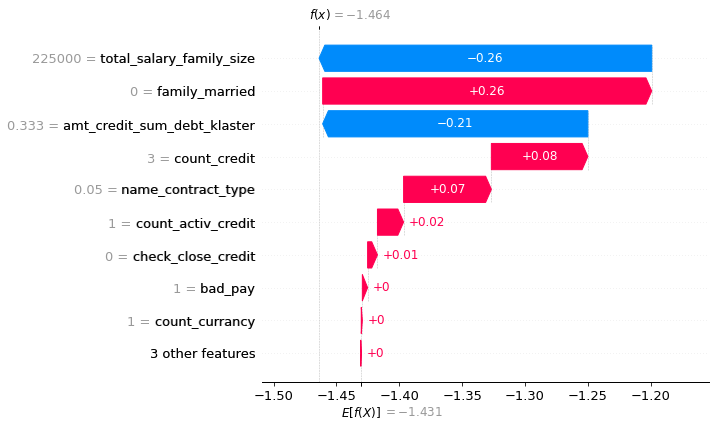

In [143]:
explainer = shap.Explainer(model_cb)
shap_values = explainer(train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

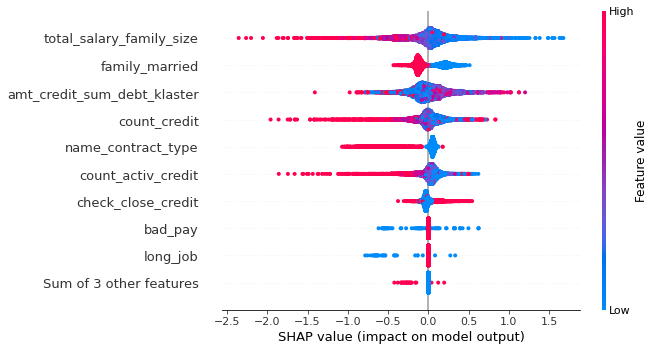

In [144]:
shap.plots.beeswarm(shap_values)

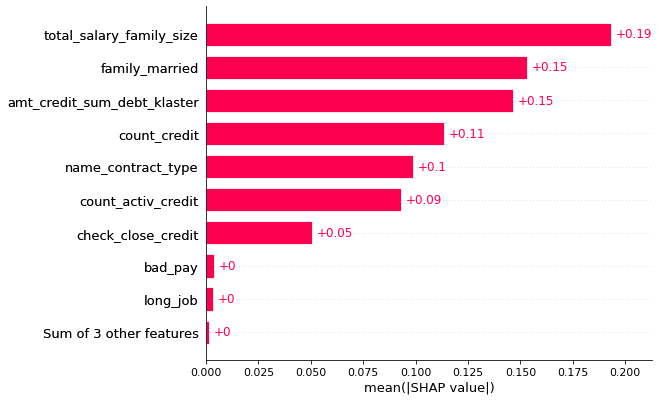

In [145]:
shap.plots.bar(shap_values)

In [146]:
data = data.drop("bad_pay", 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [147]:
# x_train, x_valid, y_train, y_valid = train_split(data)

In [148]:
train, test, target, test_id = train_split(data)

In [149]:
model_cb2 = cb.CatBoostClassifier()
cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model_cb2, metric=roc_auc_score, cv_strategy=cv_strategy
)

(1334, 11) 1334
Learning rate set to 0.010592
0:	learn: 0.6894480	total: 1.82ms	remaining: 1.81s
1:	learn: 0.6858992	total: 4.01ms	remaining: 2s
2:	learn: 0.6825024	total: 6.81ms	remaining: 2.26s
3:	learn: 0.6792296	total: 8.8ms	remaining: 2.19s
4:	learn: 0.6756482	total: 10.9ms	remaining: 2.16s
5:	learn: 0.6724032	total: 13.4ms	remaining: 2.22s
6:	learn: 0.6691972	total: 15.2ms	remaining: 2.15s
7:	learn: 0.6661831	total: 17.4ms	remaining: 2.16s
8:	learn: 0.6632233	total: 18.9ms	remaining: 2.09s
9:	learn: 0.6601239	total: 20.7ms	remaining: 2.04s
10:	learn: 0.6570880	total: 23.3ms	remaining: 2.09s
11:	learn: 0.6542279	total: 25.3ms	remaining: 2.08s
12:	learn: 0.6513713	total: 27.9ms	remaining: 2.12s
13:	learn: 0.6485485	total: 29.3ms	remaining: 2.06s
14:	learn: 0.6459318	total: 30.4ms	remaining: 2s
15:	learn: 0.6433277	total: 31.8ms	remaining: 1.95s
16:	learn: 0.6406852	total: 33.2ms	remaining: 1.92s
17:	learn: 0.6381598	total: 34.6ms	remaining: 1.89s
18:	learn: 0.6357613	total: 35.8ms	

230:	learn: 0.4969849	total: 325ms	remaining: 1.08s
231:	learn: 0.4969687	total: 326ms	remaining: 1.08s
232:	learn: 0.4967945	total: 328ms	remaining: 1.08s
233:	learn: 0.4966781	total: 329ms	remaining: 1.08s
234:	learn: 0.4963884	total: 330ms	remaining: 1.07s
235:	learn: 0.4962006	total: 332ms	remaining: 1.07s
236:	learn: 0.4959707	total: 333ms	remaining: 1.07s
237:	learn: 0.4956216	total: 334ms	remaining: 1.07s
238:	learn: 0.4955190	total: 336ms	remaining: 1.07s
239:	learn: 0.4953055	total: 337ms	remaining: 1.07s
240:	learn: 0.4952089	total: 339ms	remaining: 1.07s
241:	learn: 0.4948846	total: 340ms	remaining: 1.06s
242:	learn: 0.4945250	total: 341ms	remaining: 1.06s
243:	learn: 0.4943973	total: 343ms	remaining: 1.06s
244:	learn: 0.4941870	total: 344ms	remaining: 1.06s
245:	learn: 0.4939740	total: 345ms	remaining: 1.06s
246:	learn: 0.4937639	total: 347ms	remaining: 1.06s
247:	learn: 0.4934992	total: 348ms	remaining: 1.05s
248:	learn: 0.4934907	total: 349ms	remaining: 1.05s
249:	learn: 

494:	learn: 0.4525301	total: 673ms	remaining: 687ms
495:	learn: 0.4523602	total: 675ms	remaining: 686ms
496:	learn: 0.4522921	total: 676ms	remaining: 684ms
497:	learn: 0.4522033	total: 677ms	remaining: 683ms
498:	learn: 0.4521385	total: 679ms	remaining: 681ms
499:	learn: 0.4519494	total: 680ms	remaining: 680ms
500:	learn: 0.4517300	total: 681ms	remaining: 679ms
501:	learn: 0.4516490	total: 683ms	remaining: 677ms
502:	learn: 0.4514703	total: 684ms	remaining: 676ms
503:	learn: 0.4512780	total: 685ms	remaining: 674ms
504:	learn: 0.4511597	total: 686ms	remaining: 673ms
505:	learn: 0.4510156	total: 688ms	remaining: 672ms
506:	learn: 0.4508247	total: 689ms	remaining: 670ms
507:	learn: 0.4506777	total: 691ms	remaining: 669ms
508:	learn: 0.4505589	total: 692ms	remaining: 667ms
509:	learn: 0.4504918	total: 693ms	remaining: 666ms
510:	learn: 0.4502827	total: 695ms	remaining: 665ms
511:	learn: 0.4500755	total: 696ms	remaining: 663ms
512:	learn: 0.4500319	total: 697ms	remaining: 662ms
513:	learn: 

763:	learn: 0.4110807	total: 1.02s	remaining: 317ms
764:	learn: 0.4109524	total: 1.03s	remaining: 315ms
765:	learn: 0.4108150	total: 1.03s	remaining: 314ms
766:	learn: 0.4106381	total: 1.03s	remaining: 313ms
767:	learn: 0.4104845	total: 1.03s	remaining: 311ms
768:	learn: 0.4102989	total: 1.03s	remaining: 310ms
769:	learn: 0.4101830	total: 1.03s	remaining: 309ms
770:	learn: 0.4099836	total: 1.03s	remaining: 307ms
771:	learn: 0.4098522	total: 1.04s	remaining: 306ms
772:	learn: 0.4096293	total: 1.04s	remaining: 305ms
773:	learn: 0.4095287	total: 1.04s	remaining: 303ms
774:	learn: 0.4094309	total: 1.04s	remaining: 302ms
775:	learn: 0.4094204	total: 1.04s	remaining: 301ms
776:	learn: 0.4091722	total: 1.04s	remaining: 299ms
777:	learn: 0.4088992	total: 1.04s	remaining: 298ms
778:	learn: 0.4088151	total: 1.04s	remaining: 297ms
779:	learn: 0.4085653	total: 1.05s	remaining: 295ms
780:	learn: 0.4083305	total: 1.05s	remaining: 294ms
781:	learn: 0.4080962	total: 1.05s	remaining: 293ms
782:	learn: 

1:	learn: 0.6857361	total: 4.38ms	remaining: 2.18s
2:	learn: 0.6822572	total: 7.37ms	remaining: 2.45s
3:	learn: 0.6788887	total: 8.84ms	remaining: 2.2s
4:	learn: 0.6756606	total: 10.8ms	remaining: 2.15s
5:	learn: 0.6723873	total: 12.7ms	remaining: 2.11s
6:	learn: 0.6692959	total: 14.3ms	remaining: 2.02s
7:	learn: 0.6659167	total: 15.9ms	remaining: 1.97s
8:	learn: 0.6627938	total: 17.8ms	remaining: 1.96s
9:	learn: 0.6597639	total: 20.5ms	remaining: 2.03s
10:	learn: 0.6565580	total: 22.7ms	remaining: 2.04s
11:	learn: 0.6535647	total: 24.3ms	remaining: 2s
12:	learn: 0.6508386	total: 25.6ms	remaining: 1.94s
13:	learn: 0.6481785	total: 26.8ms	remaining: 1.89s
14:	learn: 0.6454729	total: 28.1ms	remaining: 1.85s
15:	learn: 0.6429057	total: 29.5ms	remaining: 1.81s
16:	learn: 0.6402917	total: 30.8ms	remaining: 1.78s
17:	learn: 0.6377229	total: 32.1ms	remaining: 1.75s
18:	learn: 0.6352553	total: 33.6ms	remaining: 1.73s
19:	learn: 0.6328975	total: 34.9ms	remaining: 1.71s
20:	learn: 0.6305766	tota

255:	learn: 0.4860742	total: 351ms	remaining: 1.02s
256:	learn: 0.4859103	total: 352ms	remaining: 1.02s
257:	learn: 0.4858109	total: 353ms	remaining: 1.02s
258:	learn: 0.4856469	total: 355ms	remaining: 1.01s
259:	learn: 0.4855315	total: 356ms	remaining: 1.01s
260:	learn: 0.4854487	total: 357ms	remaining: 1.01s
261:	learn: 0.4851304	total: 359ms	remaining: 1.01s
262:	learn: 0.4849260	total: 360ms	remaining: 1.01s
263:	learn: 0.4847271	total: 361ms	remaining: 1.01s
264:	learn: 0.4845979	total: 362ms	remaining: 1s
265:	learn: 0.4844506	total: 364ms	remaining: 1s
266:	learn: 0.4840864	total: 365ms	remaining: 1s
267:	learn: 0.4839022	total: 366ms	remaining: 1s
268:	learn: 0.4837660	total: 368ms	remaining: 999ms
269:	learn: 0.4836187	total: 369ms	remaining: 997ms
270:	learn: 0.4833029	total: 370ms	remaining: 996ms
271:	learn: 0.4830844	total: 372ms	remaining: 994ms
272:	learn: 0.4828483	total: 373ms	remaining: 993ms
273:	learn: 0.4825742	total: 374ms	remaining: 991ms
274:	learn: 0.4825014	to

522:	learn: 0.4401314	total: 700ms	remaining: 638ms
523:	learn: 0.4399703	total: 701ms	remaining: 637ms
524:	learn: 0.4397759	total: 703ms	remaining: 636ms
525:	learn: 0.4397432	total: 704ms	remaining: 635ms
526:	learn: 0.4395265	total: 705ms	remaining: 633ms
527:	learn: 0.4393092	total: 707ms	remaining: 632ms
528:	learn: 0.4391852	total: 708ms	remaining: 631ms
529:	learn: 0.4390663	total: 710ms	remaining: 629ms
530:	learn: 0.4388609	total: 711ms	remaining: 628ms
531:	learn: 0.4387597	total: 713ms	remaining: 627ms
532:	learn: 0.4386201	total: 714ms	remaining: 626ms
533:	learn: 0.4384344	total: 715ms	remaining: 624ms
534:	learn: 0.4383956	total: 717ms	remaining: 623ms
535:	learn: 0.4382045	total: 718ms	remaining: 622ms
536:	learn: 0.4380095	total: 720ms	remaining: 620ms
537:	learn: 0.4378509	total: 721ms	remaining: 619ms
538:	learn: 0.4376681	total: 722ms	remaining: 618ms
539:	learn: 0.4375907	total: 723ms	remaining: 616ms
540:	learn: 0.4374398	total: 725ms	remaining: 615ms
541:	learn: 

784:	learn: 0.4003946	total: 1.05s	remaining: 287ms
785:	learn: 0.4003062	total: 1.05s	remaining: 286ms
786:	learn: 0.4002444	total: 1.05s	remaining: 284ms
787:	learn: 0.4001610	total: 1.05s	remaining: 283ms
788:	learn: 0.3999065	total: 1.05s	remaining: 282ms
789:	learn: 0.3998174	total: 1.05s	remaining: 280ms
790:	learn: 0.3996942	total: 1.06s	remaining: 279ms
791:	learn: 0.3995233	total: 1.06s	remaining: 278ms
792:	learn: 0.3993400	total: 1.06s	remaining: 277ms
793:	learn: 0.3992208	total: 1.06s	remaining: 275ms
794:	learn: 0.3991208	total: 1.06s	remaining: 274ms
795:	learn: 0.3989004	total: 1.06s	remaining: 273ms
796:	learn: 0.3986946	total: 1.06s	remaining: 271ms
797:	learn: 0.3985882	total: 1.07s	remaining: 270ms
798:	learn: 0.3984648	total: 1.07s	remaining: 269ms
799:	learn: 0.3982934	total: 1.07s	remaining: 267ms
800:	learn: 0.3981340	total: 1.07s	remaining: 266ms
801:	learn: 0.3980213	total: 1.07s	remaining: 265ms
802:	learn: 0.3977171	total: 1.07s	remaining: 263ms
803:	learn: 

4:	learn: 0.6737389	total: 28.2ms	remaining: 5.62s
5:	learn: 0.6703436	total: 33.1ms	remaining: 5.48s
6:	learn: 0.6666372	total: 37.6ms	remaining: 5.33s
7:	learn: 0.6631795	total: 40.8ms	remaining: 5.06s
8:	learn: 0.6597284	total: 42.2ms	remaining: 4.64s
9:	learn: 0.6562939	total: 43.5ms	remaining: 4.3s
10:	learn: 0.6527429	total: 44.8ms	remaining: 4.03s
11:	learn: 0.6494312	total: 46.2ms	remaining: 3.81s
12:	learn: 0.6464501	total: 47.5ms	remaining: 3.6s
13:	learn: 0.6434256	total: 48.7ms	remaining: 3.43s
14:	learn: 0.6404367	total: 49.9ms	remaining: 3.28s
15:	learn: 0.6374451	total: 51.3ms	remaining: 3.15s
16:	learn: 0.6346621	total: 52.7ms	remaining: 3.05s
17:	learn: 0.6319263	total: 54ms	remaining: 2.94s
18:	learn: 0.6292672	total: 55.4ms	remaining: 2.86s
19:	learn: 0.6266799	total: 56.8ms	remaining: 2.78s
20:	learn: 0.6239981	total: 58.6ms	remaining: 2.73s
21:	learn: 0.6215373	total: 60.3ms	remaining: 2.68s
22:	learn: 0.6191325	total: 61.8ms	remaining: 2.62s
23:	learn: 0.6167846	t

247:	learn: 0.4789604	total: 366ms	remaining: 1.11s
248:	learn: 0.4786172	total: 368ms	remaining: 1.11s
249:	learn: 0.4784803	total: 369ms	remaining: 1.11s
250:	learn: 0.4781833	total: 370ms	remaining: 1.1s
251:	learn: 0.4779155	total: 372ms	remaining: 1.1s
252:	learn: 0.4775846	total: 373ms	remaining: 1.1s
253:	learn: 0.4774461	total: 375ms	remaining: 1.1s
254:	learn: 0.4770964	total: 376ms	remaining: 1.1s
255:	learn: 0.4768555	total: 377ms	remaining: 1.1s
256:	learn: 0.4767683	total: 379ms	remaining: 1.09s
257:	learn: 0.4765217	total: 380ms	remaining: 1.09s
258:	learn: 0.4761934	total: 382ms	remaining: 1.09s
259:	learn: 0.4760215	total: 383ms	remaining: 1.09s
260:	learn: 0.4757317	total: 384ms	remaining: 1.09s
261:	learn: 0.4755047	total: 386ms	remaining: 1.09s
262:	learn: 0.4752722	total: 387ms	remaining: 1.08s
263:	learn: 0.4750991	total: 389ms	remaining: 1.08s
264:	learn: 0.4748115	total: 390ms	remaining: 1.08s
265:	learn: 0.4745412	total: 392ms	remaining: 1.08s
266:	learn: 0.4744

508:	learn: 0.4357288	total: 715ms	remaining: 690ms
509:	learn: 0.4357214	total: 716ms	remaining: 688ms
510:	learn: 0.4356037	total: 718ms	remaining: 687ms
511:	learn: 0.4352613	total: 719ms	remaining: 685ms
512:	learn: 0.4351274	total: 720ms	remaining: 684ms
513:	learn: 0.4349480	total: 722ms	remaining: 682ms
514:	learn: 0.4347635	total: 723ms	remaining: 681ms
515:	learn: 0.4346412	total: 724ms	remaining: 679ms
516:	learn: 0.4344283	total: 726ms	remaining: 678ms
517:	learn: 0.4342696	total: 727ms	remaining: 677ms
518:	learn: 0.4341695	total: 729ms	remaining: 675ms
519:	learn: 0.4340696	total: 730ms	remaining: 674ms
520:	learn: 0.4339779	total: 731ms	remaining: 672ms
521:	learn: 0.4337679	total: 733ms	remaining: 671ms
522:	learn: 0.4337410	total: 734ms	remaining: 670ms
523:	learn: 0.4335615	total: 736ms	remaining: 668ms
524:	learn: 0.4333646	total: 737ms	remaining: 667ms
525:	learn: 0.4331363	total: 738ms	remaining: 665ms
526:	learn: 0.4330305	total: 740ms	remaining: 664ms
527:	learn: 

772:	learn: 0.3969181	total: 1.06s	remaining: 313ms
773:	learn: 0.3967376	total: 1.07s	remaining: 312ms
774:	learn: 0.3966782	total: 1.07s	remaining: 310ms
775:	learn: 0.3966121	total: 1.07s	remaining: 309ms
776:	learn: 0.3963723	total: 1.07s	remaining: 307ms
777:	learn: 0.3960727	total: 1.07s	remaining: 306ms
778:	learn: 0.3960137	total: 1.07s	remaining: 305ms
779:	learn: 0.3958779	total: 1.07s	remaining: 303ms
780:	learn: 0.3957166	total: 1.08s	remaining: 302ms
781:	learn: 0.3956208	total: 1.08s	remaining: 301ms
782:	learn: 0.3953700	total: 1.08s	remaining: 299ms
783:	learn: 0.3951239	total: 1.08s	remaining: 298ms
784:	learn: 0.3949955	total: 1.08s	remaining: 297ms
785:	learn: 0.3949263	total: 1.08s	remaining: 295ms
786:	learn: 0.3946945	total: 1.08s	remaining: 294ms
787:	learn: 0.3945336	total: 1.09s	remaining: 292ms
788:	learn: 0.3944292	total: 1.09s	remaining: 291ms
789:	learn: 0.3943903	total: 1.09s	remaining: 290ms
790:	learn: 0.3943397	total: 1.09s	remaining: 288ms
791:	learn: 

8:	learn: 0.6621845	total: 14.5ms	remaining: 1.6s
9:	learn: 0.6589975	total: 16.5ms	remaining: 1.64s
10:	learn: 0.6558165	total: 18.4ms	remaining: 1.65s
11:	learn: 0.6531028	total: 20.2ms	remaining: 1.66s
12:	learn: 0.6503011	total: 21.9ms	remaining: 1.66s
13:	learn: 0.6474931	total: 23.8ms	remaining: 1.68s
14:	learn: 0.6447677	total: 25.6ms	remaining: 1.68s
15:	learn: 0.6420311	total: 27.5ms	remaining: 1.69s
16:	learn: 0.6396279	total: 29.3ms	remaining: 1.69s
17:	learn: 0.6370808	total: 31.2ms	remaining: 1.7s
18:	learn: 0.6344917	total: 33ms	remaining: 1.7s
19:	learn: 0.6321527	total: 34.6ms	remaining: 1.7s
20:	learn: 0.6297795	total: 36ms	remaining: 1.68s
21:	learn: 0.6275028	total: 37.2ms	remaining: 1.66s
22:	learn: 0.6250486	total: 38.6ms	remaining: 1.64s
23:	learn: 0.6226712	total: 40ms	remaining: 1.63s
24:	learn: 0.6205606	total: 41.4ms	remaining: 1.61s
25:	learn: 0.6185190	total: 42.5ms	remaining: 1.59s
26:	learn: 0.6164245	total: 43.8ms	remaining: 1.58s
27:	learn: 0.6144165	tot

270:	learn: 0.4851439	total: 362ms	remaining: 974ms
271:	learn: 0.4850411	total: 363ms	remaining: 973ms
272:	learn: 0.4849846	total: 365ms	remaining: 971ms
273:	learn: 0.4847298	total: 366ms	remaining: 969ms
274:	learn: 0.4846270	total: 367ms	remaining: 968ms
275:	learn: 0.4845676	total: 368ms	remaining: 967ms
276:	learn: 0.4844481	total: 370ms	remaining: 965ms
277:	learn: 0.4842257	total: 371ms	remaining: 964ms
278:	learn: 0.4838972	total: 373ms	remaining: 963ms
279:	learn: 0.4837972	total: 374ms	remaining: 962ms
280:	learn: 0.4837612	total: 375ms	remaining: 959ms
281:	learn: 0.4835243	total: 376ms	remaining: 958ms
282:	learn: 0.4834572	total: 377ms	remaining: 955ms
283:	learn: 0.4833847	total: 378ms	remaining: 954ms
284:	learn: 0.4831661	total: 380ms	remaining: 952ms
285:	learn: 0.4830787	total: 381ms	remaining: 951ms
286:	learn: 0.4829139	total: 382ms	remaining: 949ms
287:	learn: 0.4825769	total: 383ms	remaining: 948ms
288:	learn: 0.4823302	total: 385ms	remaining: 947ms
289:	learn: 

539:	learn: 0.4437463	total: 711ms	remaining: 606ms
540:	learn: 0.4436228	total: 713ms	remaining: 605ms
541:	learn: 0.4436146	total: 714ms	remaining: 603ms
542:	learn: 0.4435724	total: 715ms	remaining: 602ms
543:	learn: 0.4435225	total: 716ms	remaining: 601ms
544:	learn: 0.4434661	total: 718ms	remaining: 599ms
545:	learn: 0.4432586	total: 719ms	remaining: 598ms
546:	learn: 0.4431328	total: 720ms	remaining: 597ms
547:	learn: 0.4428839	total: 722ms	remaining: 595ms
548:	learn: 0.4428786	total: 723ms	remaining: 594ms
549:	learn: 0.4428403	total: 724ms	remaining: 592ms
550:	learn: 0.4426107	total: 725ms	remaining: 591ms
551:	learn: 0.4424205	total: 726ms	remaining: 589ms
552:	learn: 0.4422537	total: 728ms	remaining: 588ms
553:	learn: 0.4420949	total: 729ms	remaining: 587ms
554:	learn: 0.4418161	total: 730ms	remaining: 586ms
555:	learn: 0.4417138	total: 732ms	remaining: 584ms
556:	learn: 0.4416688	total: 733ms	remaining: 583ms
557:	learn: 0.4415061	total: 734ms	remaining: 582ms
558:	learn: 

808:	learn: 0.4054485	total: 1.06s	remaining: 250ms
809:	learn: 0.4053126	total: 1.06s	remaining: 249ms
810:	learn: 0.4052659	total: 1.06s	remaining: 248ms
811:	learn: 0.4050866	total: 1.06s	remaining: 246ms
812:	learn: 0.4049418	total: 1.06s	remaining: 245ms
813:	learn: 0.4048255	total: 1.07s	remaining: 244ms
814:	learn: 0.4047179	total: 1.07s	remaining: 243ms
815:	learn: 0.4044763	total: 1.07s	remaining: 241ms
816:	learn: 0.4043561	total: 1.07s	remaining: 240ms
817:	learn: 0.4043071	total: 1.07s	remaining: 239ms
818:	learn: 0.4042395	total: 1.07s	remaining: 238ms
819:	learn: 0.4041276	total: 1.08s	remaining: 236ms
820:	learn: 0.4038602	total: 1.08s	remaining: 235ms
821:	learn: 0.4036839	total: 1.08s	remaining: 234ms
822:	learn: 0.4035046	total: 1.08s	remaining: 232ms
823:	learn: 0.4032337	total: 1.08s	remaining: 231ms
824:	learn: 0.4030932	total: 1.08s	remaining: 230ms
825:	learn: 0.4029824	total: 1.08s	remaining: 228ms
826:	learn: 0.4028535	total: 1.08s	remaining: 227ms
827:	learn: 

37:	learn: 0.5857143	total: 61.2ms	remaining: 1.55s
38:	learn: 0.5840711	total: 62.7ms	remaining: 1.54s
39:	learn: 0.5824332	total: 64.1ms	remaining: 1.54s
40:	learn: 0.5806454	total: 65.6ms	remaining: 1.53s
41:	learn: 0.5788298	total: 67ms	remaining: 1.53s
42:	learn: 0.5769360	total: 68.4ms	remaining: 1.52s
43:	learn: 0.5754060	total: 69.8ms	remaining: 1.52s
44:	learn: 0.5739124	total: 71.2ms	remaining: 1.51s
45:	learn: 0.5724137	total: 72.8ms	remaining: 1.51s
46:	learn: 0.5709875	total: 74.3ms	remaining: 1.51s
47:	learn: 0.5695828	total: 75.8ms	remaining: 1.5s
48:	learn: 0.5682667	total: 77.1ms	remaining: 1.5s
49:	learn: 0.5669897	total: 78.2ms	remaining: 1.49s
50:	learn: 0.5655913	total: 79.6ms	remaining: 1.48s
51:	learn: 0.5643997	total: 80.4ms	remaining: 1.47s
52:	learn: 0.5629758	total: 81.7ms	remaining: 1.46s
53:	learn: 0.5615203	total: 83ms	remaining: 1.45s
54:	learn: 0.5603719	total: 84.1ms	remaining: 1.44s
55:	learn: 0.5590436	total: 85.4ms	remaining: 1.44s
56:	learn: 0.55785

310:	learn: 0.4658567	total: 409ms	remaining: 906ms
311:	learn: 0.4656916	total: 410ms	remaining: 905ms
312:	learn: 0.4655318	total: 412ms	remaining: 903ms
313:	learn: 0.4652334	total: 413ms	remaining: 902ms
314:	learn: 0.4651540	total: 414ms	remaining: 901ms
315:	learn: 0.4649155	total: 416ms	remaining: 900ms
316:	learn: 0.4647989	total: 417ms	remaining: 899ms
317:	learn: 0.4643706	total: 419ms	remaining: 898ms
318:	learn: 0.4643148	total: 420ms	remaining: 897ms
319:	learn: 0.4641832	total: 422ms	remaining: 896ms
320:	learn: 0.4636735	total: 423ms	remaining: 895ms
321:	learn: 0.4635057	total: 425ms	remaining: 895ms
322:	learn: 0.4632562	total: 426ms	remaining: 893ms
323:	learn: 0.4631484	total: 428ms	remaining: 892ms
324:	learn: 0.4628074	total: 429ms	remaining: 891ms
325:	learn: 0.4624892	total: 431ms	remaining: 890ms
326:	learn: 0.4622208	total: 432ms	remaining: 890ms
327:	learn: 0.4620588	total: 434ms	remaining: 888ms
328:	learn: 0.4619602	total: 435ms	remaining: 887ms
329:	learn: 

563:	learn: 0.4271145	total: 756ms	remaining: 584ms
564:	learn: 0.4269409	total: 757ms	remaining: 583ms
565:	learn: 0.4267117	total: 759ms	remaining: 582ms
566:	learn: 0.4266598	total: 760ms	remaining: 580ms
567:	learn: 0.4265835	total: 761ms	remaining: 579ms
568:	learn: 0.4265156	total: 763ms	remaining: 578ms
569:	learn: 0.4262845	total: 764ms	remaining: 576ms
570:	learn: 0.4260955	total: 765ms	remaining: 575ms
571:	learn: 0.4259696	total: 767ms	remaining: 574ms
572:	learn: 0.4257612	total: 768ms	remaining: 572ms
573:	learn: 0.4256739	total: 770ms	remaining: 571ms
574:	learn: 0.4254960	total: 771ms	remaining: 570ms
575:	learn: 0.4254069	total: 772ms	remaining: 569ms
576:	learn: 0.4252738	total: 774ms	remaining: 567ms
577:	learn: 0.4252282	total: 775ms	remaining: 566ms
578:	learn: 0.4251423	total: 776ms	remaining: 565ms
579:	learn: 0.4249600	total: 778ms	remaining: 563ms
580:	learn: 0.4249217	total: 779ms	remaining: 562ms
581:	learn: 0.4248050	total: 780ms	remaining: 560ms
582:	learn: 

824:	learn: 0.3902110	total: 1.1s	remaining: 234ms
825:	learn: 0.3900625	total: 1.1s	remaining: 233ms
826:	learn: 0.3898875	total: 1.11s	remaining: 232ms
827:	learn: 0.3897769	total: 1.11s	remaining: 230ms
828:	learn: 0.3896332	total: 1.11s	remaining: 229ms
829:	learn: 0.3894676	total: 1.11s	remaining: 227ms
830:	learn: 0.3893586	total: 1.11s	remaining: 226ms
831:	learn: 0.3891507	total: 1.11s	remaining: 225ms
832:	learn: 0.3889906	total: 1.11s	remaining: 224ms
833:	learn: 0.3889350	total: 1.12s	remaining: 222ms
834:	learn: 0.3888878	total: 1.12s	remaining: 221ms
835:	learn: 0.3887501	total: 1.12s	remaining: 220ms
836:	learn: 0.3886634	total: 1.12s	remaining: 218ms
837:	learn: 0.3885400	total: 1.12s	remaining: 217ms
838:	learn: 0.3883728	total: 1.12s	remaining: 216ms
839:	learn: 0.3883164	total: 1.12s	remaining: 214ms
840:	learn: 0.3881885	total: 1.13s	remaining: 213ms
841:	learn: 0.3879921	total: 1.13s	remaining: 211ms
842:	learn: 0.3879692	total: 1.13s	remaining: 210ms
843:	learn: 0.

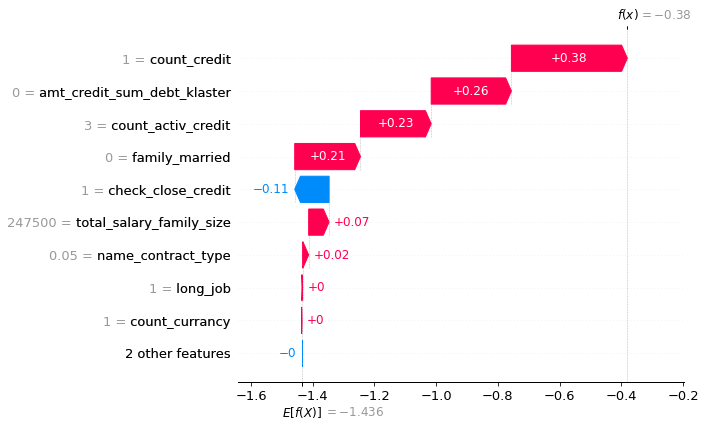

In [150]:
explainer = shap.Explainer(model_cb2)
shap_values = explainer(train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

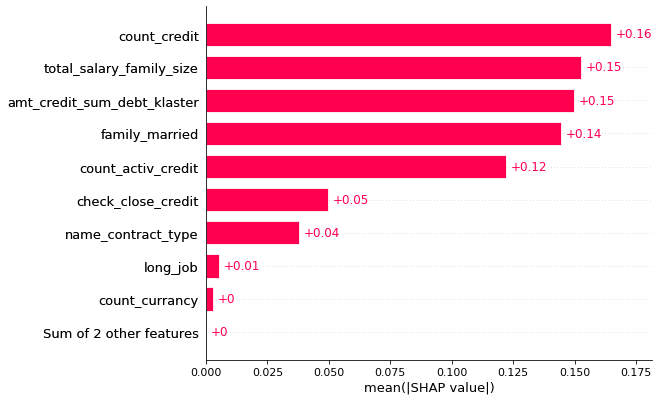

In [151]:
shap.plots.bar(shap_values)

In [152]:
data = data.drop("long_job", 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [153]:
data.columns

Index(['target', 'application_number', 'total_salary_family_size',
       'amt_credit_sum_debt_klaster', 'count_credit', 'family_married',
       'count_activ_credit', 'name_contract_type', 'check_close_credit',
       'count_currancy', 'age', 'bad_debt'],
      dtype='object')

In [154]:
train, test, target, test_id = train_split(data)

In [155]:
model_cb3 = cb.CatBoostClassifier()
cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model_cb3, metric=roc_auc_score, cv_strategy=cv_strategy
)

(1334, 10) 1334
Learning rate set to 0.010592
0:	learn: 0.6893201	total: 4ms	remaining: 4s
1:	learn: 0.6854533	total: 8.18ms	remaining: 4.08s
2:	learn: 0.6819538	total: 12.3ms	remaining: 4.09s
3:	learn: 0.6784102	total: 16.1ms	remaining: 4s
4:	learn: 0.6749213	total: 20.1ms	remaining: 3.99s
5:	learn: 0.6717735	total: 22.7ms	remaining: 3.75s
6:	learn: 0.6682718	total: 25.5ms	remaining: 3.62s
7:	learn: 0.6651600	total: 28.1ms	remaining: 3.48s
8:	learn: 0.6621193	total: 31ms	remaining: 3.41s
9:	learn: 0.6587656	total: 34ms	remaining: 3.36s
10:	learn: 0.6559556	total: 36.1ms	remaining: 3.25s
11:	learn: 0.6531804	total: 38ms	remaining: 3.13s
12:	learn: 0.6504486	total: 40.8ms	remaining: 3.1s
13:	learn: 0.6477025	total: 43.8ms	remaining: 3.08s
14:	learn: 0.6449911	total: 46.7ms	remaining: 3.07s
15:	learn: 0.6421569	total: 48.8ms	remaining: 3s
16:	learn: 0.6396811	total: 49.8ms	remaining: 2.88s
17:	learn: 0.6371245	total: 51.2ms	remaining: 2.79s
18:	learn: 0.6347265	total: 52.6ms	remaining: 2

224:	learn: 0.4964383	total: 331ms	remaining: 1.14s
225:	learn: 0.4962437	total: 332ms	remaining: 1.14s
226:	learn: 0.4961858	total: 333ms	remaining: 1.14s
227:	learn: 0.4961002	total: 335ms	remaining: 1.13s
228:	learn: 0.4959159	total: 336ms	remaining: 1.13s
229:	learn: 0.4955311	total: 337ms	remaining: 1.13s
230:	learn: 0.4952670	total: 339ms	remaining: 1.13s
231:	learn: 0.4949792	total: 340ms	remaining: 1.13s
232:	learn: 0.4946703	total: 342ms	remaining: 1.12s
233:	learn: 0.4945248	total: 343ms	remaining: 1.12s
234:	learn: 0.4942899	total: 344ms	remaining: 1.12s
235:	learn: 0.4940783	total: 346ms	remaining: 1.12s
236:	learn: 0.4935906	total: 347ms	remaining: 1.12s
237:	learn: 0.4932867	total: 349ms	remaining: 1.11s
238:	learn: 0.4930918	total: 350ms	remaining: 1.11s
239:	learn: 0.4928549	total: 351ms	remaining: 1.11s
240:	learn: 0.4925015	total: 353ms	remaining: 1.11s
241:	learn: 0.4923565	total: 355ms	remaining: 1.11s
242:	learn: 0.4920819	total: 356ms	remaining: 1.11s
243:	learn: 

490:	learn: 0.4504932	total: 679ms	remaining: 704ms
491:	learn: 0.4503529	total: 680ms	remaining: 702ms
492:	learn: 0.4501801	total: 682ms	remaining: 701ms
493:	learn: 0.4500779	total: 683ms	remaining: 699ms
494:	learn: 0.4498185	total: 684ms	remaining: 698ms
495:	learn: 0.4496468	total: 686ms	remaining: 697ms
496:	learn: 0.4495406	total: 687ms	remaining: 695ms
497:	learn: 0.4493778	total: 688ms	remaining: 694ms
498:	learn: 0.4491334	total: 689ms	remaining: 692ms
499:	learn: 0.4489047	total: 691ms	remaining: 691ms
500:	learn: 0.4487447	total: 692ms	remaining: 689ms
501:	learn: 0.4486293	total: 693ms	remaining: 688ms
502:	learn: 0.4484499	total: 695ms	remaining: 686ms
503:	learn: 0.4483136	total: 696ms	remaining: 685ms
504:	learn: 0.4482052	total: 697ms	remaining: 683ms
505:	learn: 0.4480892	total: 698ms	remaining: 682ms
506:	learn: 0.4480004	total: 700ms	remaining: 680ms
507:	learn: 0.4478437	total: 701ms	remaining: 679ms
508:	learn: 0.4477571	total: 702ms	remaining: 677ms
509:	learn: 

755:	learn: 0.4098723	total: 1.03s	remaining: 331ms
756:	learn: 0.4097136	total: 1.03s	remaining: 330ms
757:	learn: 0.4096305	total: 1.03s	remaining: 329ms
758:	learn: 0.4094514	total: 1.03s	remaining: 327ms
759:	learn: 0.4092763	total: 1.03s	remaining: 326ms
760:	learn: 0.4090721	total: 1.03s	remaining: 325ms
761:	learn: 0.4088620	total: 1.03s	remaining: 323ms
762:	learn: 0.4087450	total: 1.03s	remaining: 322ms
763:	learn: 0.4086096	total: 1.04s	remaining: 320ms
764:	learn: 0.4085074	total: 1.04s	remaining: 319ms
765:	learn: 0.4082964	total: 1.04s	remaining: 318ms
766:	learn: 0.4080425	total: 1.04s	remaining: 316ms
767:	learn: 0.4078132	total: 1.04s	remaining: 315ms
768:	learn: 0.4075737	total: 1.04s	remaining: 314ms
769:	learn: 0.4073879	total: 1.04s	remaining: 312ms
770:	learn: 0.4072116	total: 1.05s	remaining: 311ms
771:	learn: 0.4070928	total: 1.05s	remaining: 309ms
772:	learn: 0.4068540	total: 1.05s	remaining: 308ms
773:	learn: 0.4066301	total: 1.05s	remaining: 307ms
774:	learn: 

0:	learn: 0.6892626	total: 1.45ms	remaining: 1.45s
1:	learn: 0.6854006	total: 2.88ms	remaining: 1.44s
2:	learn: 0.6818302	total: 4.18ms	remaining: 1.39s
3:	learn: 0.6781862	total: 5.42ms	remaining: 1.35s
4:	learn: 0.6743623	total: 6.73ms	remaining: 1.34s
5:	learn: 0.6712086	total: 7.62ms	remaining: 1.26s
6:	learn: 0.6679594	total: 8.97ms	remaining: 1.27s
7:	learn: 0.6648450	total: 10.3ms	remaining: 1.27s
8:	learn: 0.6617588	total: 11.6ms	remaining: 1.27s
9:	learn: 0.6584572	total: 12.9ms	remaining: 1.27s
10:	learn: 0.6556473	total: 13.8ms	remaining: 1.24s
11:	learn: 0.6528491	total: 14.8ms	remaining: 1.22s
12:	learn: 0.6499821	total: 16.1ms	remaining: 1.22s
13:	learn: 0.6473137	total: 17.4ms	remaining: 1.23s
14:	learn: 0.6444873	total: 18.7ms	remaining: 1.23s
15:	learn: 0.6415826	total: 19.9ms	remaining: 1.23s
16:	learn: 0.6390720	total: 21ms	remaining: 1.21s
17:	learn: 0.6364905	total: 22.4ms	remaining: 1.22s
18:	learn: 0.6340612	total: 24ms	remaining: 1.24s
19:	learn: 0.6317142	total

261:	learn: 0.4800299	total: 346ms	remaining: 974ms
262:	learn: 0.4799847	total: 347ms	remaining: 973ms
263:	learn: 0.4797787	total: 349ms	remaining: 972ms
264:	learn: 0.4797415	total: 350ms	remaining: 970ms
265:	learn: 0.4794973	total: 351ms	remaining: 968ms
266:	learn: 0.4792393	total: 352ms	remaining: 967ms
267:	learn: 0.4790746	total: 353ms	remaining: 965ms
268:	learn: 0.4788964	total: 355ms	remaining: 964ms
269:	learn: 0.4787167	total: 356ms	remaining: 963ms
270:	learn: 0.4784001	total: 357ms	remaining: 962ms
271:	learn: 0.4783262	total: 359ms	remaining: 960ms
272:	learn: 0.4780638	total: 360ms	remaining: 959ms
273:	learn: 0.4778954	total: 361ms	remaining: 958ms
274:	learn: 0.4776683	total: 363ms	remaining: 957ms
275:	learn: 0.4774366	total: 364ms	remaining: 955ms
276:	learn: 0.4772275	total: 365ms	remaining: 954ms
277:	learn: 0.4769140	total: 367ms	remaining: 952ms
278:	learn: 0.4767475	total: 368ms	remaining: 951ms
279:	learn: 0.4764622	total: 369ms	remaining: 950ms
280:	learn: 

523:	learn: 0.4361115	total: 694ms	remaining: 631ms
524:	learn: 0.4359487	total: 696ms	remaining: 630ms
525:	learn: 0.4357297	total: 697ms	remaining: 628ms
526:	learn: 0.4356108	total: 698ms	remaining: 627ms
527:	learn: 0.4354183	total: 700ms	remaining: 626ms
528:	learn: 0.4353951	total: 701ms	remaining: 624ms
529:	learn: 0.4350946	total: 702ms	remaining: 623ms
530:	learn: 0.4349194	total: 704ms	remaining: 622ms
531:	learn: 0.4348091	total: 705ms	remaining: 620ms
532:	learn: 0.4346322	total: 706ms	remaining: 619ms
533:	learn: 0.4344746	total: 708ms	remaining: 618ms
534:	learn: 0.4342810	total: 709ms	remaining: 616ms
535:	learn: 0.4340338	total: 710ms	remaining: 615ms
536:	learn: 0.4340002	total: 711ms	remaining: 613ms
537:	learn: 0.4338303	total: 713ms	remaining: 612ms
538:	learn: 0.4336754	total: 714ms	remaining: 611ms
539:	learn: 0.4334235	total: 715ms	remaining: 609ms
540:	learn: 0.4333892	total: 717ms	remaining: 608ms
541:	learn: 0.4331927	total: 718ms	remaining: 607ms
542:	learn: 

790:	learn: 0.3966660	total: 1.04s	remaining: 276ms
791:	learn: 0.3964733	total: 1.04s	remaining: 274ms
792:	learn: 0.3963284	total: 1.04s	remaining: 273ms
793:	learn: 0.3961932	total: 1.05s	remaining: 272ms
794:	learn: 0.3960348	total: 1.05s	remaining: 270ms
795:	learn: 0.3958526	total: 1.05s	remaining: 269ms
796:	learn: 0.3957054	total: 1.05s	remaining: 268ms
797:	learn: 0.3956855	total: 1.05s	remaining: 266ms
798:	learn: 0.3954563	total: 1.05s	remaining: 265ms
799:	learn: 0.3952999	total: 1.05s	remaining: 264ms
800:	learn: 0.3951638	total: 1.06s	remaining: 262ms
801:	learn: 0.3949944	total: 1.06s	remaining: 261ms
802:	learn: 0.3948908	total: 1.06s	remaining: 260ms
803:	learn: 0.3946703	total: 1.06s	remaining: 258ms
804:	learn: 0.3944787	total: 1.06s	remaining: 257ms
805:	learn: 0.3943500	total: 1.06s	remaining: 256ms
806:	learn: 0.3940508	total: 1.06s	remaining: 255ms
807:	learn: 0.3939191	total: 1.06s	remaining: 253ms
808:	learn: 0.3937818	total: 1.07s	remaining: 252ms
809:	learn: 

29:	learn: 0.6037307	total: 37.9ms	remaining: 1.23s
30:	learn: 0.6013152	total: 39.4ms	remaining: 1.23s
31:	learn: 0.5992100	total: 40.8ms	remaining: 1.23s
32:	learn: 0.5971885	total: 42.1ms	remaining: 1.23s
33:	learn: 0.5950603	total: 43.4ms	remaining: 1.23s
34:	learn: 0.5929606	total: 44.8ms	remaining: 1.23s
35:	learn: 0.5909306	total: 46.2ms	remaining: 1.24s
36:	learn: 0.5890122	total: 47.8ms	remaining: 1.24s
37:	learn: 0.5874464	total: 48.6ms	remaining: 1.23s
38:	learn: 0.5855670	total: 49.9ms	remaining: 1.23s
39:	learn: 0.5840729	total: 50.8ms	remaining: 1.22s
40:	learn: 0.5824708	total: 52.2ms	remaining: 1.22s
41:	learn: 0.5807609	total: 53.5ms	remaining: 1.22s
42:	learn: 0.5791048	total: 54.8ms	remaining: 1.22s
43:	learn: 0.5776961	total: 55.9ms	remaining: 1.21s
44:	learn: 0.5761354	total: 57.2ms	remaining: 1.21s
45:	learn: 0.5744855	total: 58.6ms	remaining: 1.21s
46:	learn: 0.5727408	total: 59.9ms	remaining: 1.22s
47:	learn: 0.5715021	total: 60.7ms	remaining: 1.2s
48:	learn: 0.

298:	learn: 0.4630170	total: 386ms	remaining: 904ms
299:	learn: 0.4628056	total: 387ms	remaining: 904ms
300:	learn: 0.4626276	total: 389ms	remaining: 903ms
301:	learn: 0.4624526	total: 390ms	remaining: 901ms
302:	learn: 0.4621847	total: 391ms	remaining: 900ms
303:	learn: 0.4618933	total: 393ms	remaining: 899ms
304:	learn: 0.4616098	total: 394ms	remaining: 898ms
305:	learn: 0.4612533	total: 395ms	remaining: 896ms
306:	learn: 0.4610322	total: 397ms	remaining: 895ms
307:	learn: 0.4609345	total: 398ms	remaining: 894ms
308:	learn: 0.4607472	total: 399ms	remaining: 893ms
309:	learn: 0.4606793	total: 400ms	remaining: 891ms
310:	learn: 0.4603838	total: 402ms	remaining: 890ms
311:	learn: 0.4601672	total: 403ms	remaining: 889ms
312:	learn: 0.4600927	total: 405ms	remaining: 888ms
313:	learn: 0.4600118	total: 406ms	remaining: 887ms
314:	learn: 0.4597923	total: 407ms	remaining: 885ms
315:	learn: 0.4597661	total: 408ms	remaining: 883ms
316:	learn: 0.4596454	total: 409ms	remaining: 882ms
317:	learn: 

566:	learn: 0.4213520	total: 734ms	remaining: 561ms
567:	learn: 0.4212449	total: 736ms	remaining: 559ms
568:	learn: 0.4211326	total: 737ms	remaining: 558ms
569:	learn: 0.4210026	total: 738ms	remaining: 557ms
570:	learn: 0.4208185	total: 740ms	remaining: 556ms
571:	learn: 0.4206823	total: 741ms	remaining: 554ms
572:	learn: 0.4203694	total: 742ms	remaining: 553ms
573:	learn: 0.4201793	total: 743ms	remaining: 552ms
574:	learn: 0.4200393	total: 745ms	remaining: 550ms
575:	learn: 0.4199033	total: 746ms	remaining: 549ms
576:	learn: 0.4198179	total: 747ms	remaining: 548ms
577:	learn: 0.4196219	total: 749ms	remaining: 547ms
578:	learn: 0.4195223	total: 750ms	remaining: 545ms
579:	learn: 0.4194081	total: 751ms	remaining: 544ms
580:	learn: 0.4192888	total: 753ms	remaining: 543ms
581:	learn: 0.4192152	total: 754ms	remaining: 541ms
582:	learn: 0.4190464	total: 755ms	remaining: 540ms
583:	learn: 0.4188805	total: 756ms	remaining: 539ms
584:	learn: 0.4186719	total: 758ms	remaining: 538ms
585:	learn: 

828:	learn: 0.3836931	total: 1.08s	remaining: 223ms
829:	learn: 0.3834087	total: 1.08s	remaining: 221ms
830:	learn: 0.3831510	total: 1.08s	remaining: 220ms
831:	learn: 0.3830042	total: 1.08s	remaining: 219ms
832:	learn: 0.3829447	total: 1.08s	remaining: 218ms
833:	learn: 0.3826336	total: 1.09s	remaining: 216ms
834:	learn: 0.3824908	total: 1.09s	remaining: 215ms
835:	learn: 0.3823704	total: 1.09s	remaining: 214ms
836:	learn: 0.3823442	total: 1.09s	remaining: 212ms
837:	learn: 0.3822641	total: 1.09s	remaining: 211ms
838:	learn: 0.3820251	total: 1.09s	remaining: 210ms
839:	learn: 0.3819389	total: 1.09s	remaining: 208ms
840:	learn: 0.3818987	total: 1.09s	remaining: 207ms
841:	learn: 0.3818208	total: 1.1s	remaining: 206ms
842:	learn: 0.3816803	total: 1.1s	remaining: 205ms
843:	learn: 0.3816532	total: 1.1s	remaining: 203ms
844:	learn: 0.3814702	total: 1.1s	remaining: 202ms
845:	learn: 0.3812113	total: 1.1s	remaining: 201ms
846:	learn: 0.3810802	total: 1.1s	remaining: 199ms
847:	learn: 0.3809

70:	learn: 0.5556928	total: 91.9ms	remaining: 1.2s
71:	learn: 0.5548002	total: 93.4ms	remaining: 1.2s
72:	learn: 0.5536506	total: 94.7ms	remaining: 1.2s
73:	learn: 0.5528064	total: 96ms	remaining: 1.2s
74:	learn: 0.5518168	total: 97.3ms	remaining: 1.2s
75:	learn: 0.5509550	total: 98.7ms	remaining: 1.2s
76:	learn: 0.5503065	total: 99.8ms	remaining: 1.2s
77:	learn: 0.5495461	total: 101ms	remaining: 1.2s
78:	learn: 0.5489022	total: 102ms	remaining: 1.19s
79:	learn: 0.5481868	total: 104ms	remaining: 1.19s
80:	learn: 0.5474198	total: 105ms	remaining: 1.19s
81:	learn: 0.5465041	total: 106ms	remaining: 1.19s
82:	learn: 0.5459184	total: 107ms	remaining: 1.19s
83:	learn: 0.5450004	total: 109ms	remaining: 1.19s
84:	learn: 0.5442667	total: 110ms	remaining: 1.18s
85:	learn: 0.5437315	total: 111ms	remaining: 1.18s
86:	learn: 0.5430412	total: 112ms	remaining: 1.18s
87:	learn: 0.5422378	total: 114ms	remaining: 1.18s
88:	learn: 0.5415914	total: 115ms	remaining: 1.18s
89:	learn: 0.5410357	total: 116ms	

339:	learn: 0.4703185	total: 439ms	remaining: 851ms
340:	learn: 0.4700391	total: 440ms	remaining: 850ms
341:	learn: 0.4698629	total: 441ms	remaining: 849ms
342:	learn: 0.4697475	total: 443ms	remaining: 848ms
343:	learn: 0.4696424	total: 444ms	remaining: 847ms
344:	learn: 0.4694048	total: 445ms	remaining: 846ms
345:	learn: 0.4693397	total: 446ms	remaining: 844ms
346:	learn: 0.4691573	total: 448ms	remaining: 843ms
347:	learn: 0.4691060	total: 449ms	remaining: 841ms
348:	learn: 0.4689973	total: 450ms	remaining: 840ms
349:	learn: 0.4686294	total: 452ms	remaining: 839ms
350:	learn: 0.4685672	total: 453ms	remaining: 838ms
351:	learn: 0.4682682	total: 454ms	remaining: 836ms
352:	learn: 0.4680042	total: 456ms	remaining: 835ms
353:	learn: 0.4678000	total: 457ms	remaining: 834ms
354:	learn: 0.4676177	total: 459ms	remaining: 833ms
355:	learn: 0.4674732	total: 460ms	remaining: 832ms
356:	learn: 0.4673093	total: 461ms	remaining: 831ms
357:	learn: 0.4670325	total: 463ms	remaining: 829ms
358:	learn: 

590:	learn: 0.4300550	total: 784ms	remaining: 542ms
591:	learn: 0.4299389	total: 785ms	remaining: 541ms
592:	learn: 0.4297739	total: 787ms	remaining: 540ms
593:	learn: 0.4294774	total: 788ms	remaining: 539ms
594:	learn: 0.4293656	total: 789ms	remaining: 537ms
595:	learn: 0.4291990	total: 791ms	remaining: 536ms
596:	learn: 0.4290586	total: 792ms	remaining: 535ms
597:	learn: 0.4289427	total: 794ms	remaining: 533ms
598:	learn: 0.4288624	total: 795ms	remaining: 532ms
599:	learn: 0.4288058	total: 796ms	remaining: 531ms
600:	learn: 0.4287575	total: 799ms	remaining: 530ms
601:	learn: 0.4286344	total: 801ms	remaining: 529ms
602:	learn: 0.4285638	total: 803ms	remaining: 529ms
603:	learn: 0.4285084	total: 805ms	remaining: 528ms
604:	learn: 0.4283471	total: 807ms	remaining: 527ms
605:	learn: 0.4281135	total: 809ms	remaining: 526ms
606:	learn: 0.4280670	total: 810ms	remaining: 525ms
607:	learn: 0.4278544	total: 812ms	remaining: 524ms
608:	learn: 0.4275755	total: 814ms	remaining: 522ms
609:	learn: 

827:	learn: 0.3947165	total: 1.12s	remaining: 234ms
828:	learn: 0.3946597	total: 1.13s	remaining: 232ms
829:	learn: 0.3945319	total: 1.13s	remaining: 231ms
830:	learn: 0.3944505	total: 1.13s	remaining: 230ms
831:	learn: 0.3942036	total: 1.13s	remaining: 228ms
832:	learn: 0.3940115	total: 1.13s	remaining: 227ms
833:	learn: 0.3939317	total: 1.13s	remaining: 226ms
834:	learn: 0.3938419	total: 1.14s	remaining: 224ms
835:	learn: 0.3935254	total: 1.14s	remaining: 223ms
836:	learn: 0.3933231	total: 1.14s	remaining: 222ms
837:	learn: 0.3932143	total: 1.14s	remaining: 220ms
838:	learn: 0.3930639	total: 1.14s	remaining: 219ms
839:	learn: 0.3928372	total: 1.14s	remaining: 218ms
840:	learn: 0.3925947	total: 1.14s	remaining: 216ms
841:	learn: 0.3925224	total: 1.15s	remaining: 215ms
842:	learn: 0.3924042	total: 1.15s	remaining: 214ms
843:	learn: 0.3922282	total: 1.15s	remaining: 212ms
844:	learn: 0.3921218	total: 1.15s	remaining: 211ms
845:	learn: 0.3919796	total: 1.15s	remaining: 210ms
846:	learn: 

36:	learn: 0.5893248	total: 50.6ms	remaining: 1.32s
37:	learn: 0.5875457	total: 52.2ms	remaining: 1.32s
38:	learn: 0.5857153	total: 53.5ms	remaining: 1.32s
39:	learn: 0.5840302	total: 54.9ms	remaining: 1.32s
40:	learn: 0.5823065	total: 56.1ms	remaining: 1.31s
41:	learn: 0.5806690	total: 57.4ms	remaining: 1.31s
42:	learn: 0.5789750	total: 58.7ms	remaining: 1.31s
43:	learn: 0.5774058	total: 60ms	remaining: 1.3s
44:	learn: 0.5757484	total: 61.2ms	remaining: 1.3s
45:	learn: 0.5743262	total: 62.2ms	remaining: 1.29s
46:	learn: 0.5729678	total: 63.2ms	remaining: 1.28s
47:	learn: 0.5713530	total: 64.6ms	remaining: 1.28s
48:	learn: 0.5700079	total: 65.7ms	remaining: 1.27s
49:	learn: 0.5685158	total: 67ms	remaining: 1.27s
50:	learn: 0.5671884	total: 68.3ms	remaining: 1.27s
51:	learn: 0.5657156	total: 69.6ms	remaining: 1.27s
52:	learn: 0.5644271	total: 70.8ms	remaining: 1.26s
53:	learn: 0.5630779	total: 72.1ms	remaining: 1.26s
54:	learn: 0.5617890	total: 73.4ms	remaining: 1.26s
55:	learn: 0.56028

281:	learn: 0.4689625	total: 394ms	remaining: 1s
282:	learn: 0.4687335	total: 396ms	remaining: 1s
283:	learn: 0.4684577	total: 397ms	remaining: 1s
284:	learn: 0.4682598	total: 398ms	remaining: 999ms
285:	learn: 0.4678786	total: 400ms	remaining: 998ms
286:	learn: 0.4677820	total: 401ms	remaining: 996ms
287:	learn: 0.4675418	total: 402ms	remaining: 995ms
288:	learn: 0.4672919	total: 404ms	remaining: 993ms
289:	learn: 0.4669405	total: 405ms	remaining: 992ms
290:	learn: 0.4666709	total: 406ms	remaining: 990ms
291:	learn: 0.4665088	total: 408ms	remaining: 988ms
292:	learn: 0.4663844	total: 409ms	remaining: 987ms
293:	learn: 0.4661461	total: 410ms	remaining: 986ms
294:	learn: 0.4660481	total: 412ms	remaining: 984ms
295:	learn: 0.4659752	total: 413ms	remaining: 982ms
296:	learn: 0.4657460	total: 414ms	remaining: 981ms
297:	learn: 0.4653279	total: 416ms	remaining: 979ms
298:	learn: 0.4653235	total: 417ms	remaining: 976ms
299:	learn: 0.4651960	total: 418ms	remaining: 975ms
300:	learn: 0.4650831

538:	learn: 0.4286838	total: 741ms	remaining: 633ms
539:	learn: 0.4284993	total: 742ms	remaining: 632ms
540:	learn: 0.4283680	total: 743ms	remaining: 631ms
541:	learn: 0.4282573	total: 745ms	remaining: 629ms
542:	learn: 0.4281026	total: 746ms	remaining: 628ms
543:	learn: 0.4279473	total: 747ms	remaining: 626ms
544:	learn: 0.4277528	total: 749ms	remaining: 625ms
545:	learn: 0.4275667	total: 750ms	remaining: 624ms
546:	learn: 0.4275097	total: 751ms	remaining: 622ms
547:	learn: 0.4271831	total: 753ms	remaining: 621ms
548:	learn: 0.4271186	total: 754ms	remaining: 619ms
549:	learn: 0.4269743	total: 755ms	remaining: 618ms
550:	learn: 0.4265026	total: 757ms	remaining: 617ms
551:	learn: 0.4261296	total: 758ms	remaining: 615ms
552:	learn: 0.4260260	total: 759ms	remaining: 614ms
553:	learn: 0.4258393	total: 761ms	remaining: 612ms
554:	learn: 0.4257281	total: 762ms	remaining: 611ms
555:	learn: 0.4254880	total: 763ms	remaining: 609ms
556:	learn: 0.4254848	total: 764ms	remaining: 608ms
557:	learn: 

797:	learn: 0.3908931	total: 1.09s	remaining: 275ms
798:	learn: 0.3907720	total: 1.09s	remaining: 274ms
799:	learn: 0.3905366	total: 1.09s	remaining: 273ms
800:	learn: 0.3905357	total: 1.09s	remaining: 271ms
801:	learn: 0.3903586	total: 1.09s	remaining: 270ms
802:	learn: 0.3901260	total: 1.09s	remaining: 269ms
803:	learn: 0.3900189	total: 1.1s	remaining: 267ms
804:	learn: 0.3899525	total: 1.1s	remaining: 266ms
805:	learn: 0.3899394	total: 1.1s	remaining: 264ms
806:	learn: 0.3897286	total: 1.1s	remaining: 263ms
807:	learn: 0.3896968	total: 1.1s	remaining: 262ms
808:	learn: 0.3895987	total: 1.1s	remaining: 260ms
809:	learn: 0.3894576	total: 1.1s	remaining: 259ms
810:	learn: 0.3893955	total: 1.1s	remaining: 258ms
811:	learn: 0.3892651	total: 1.11s	remaining: 256ms
812:	learn: 0.3891099	total: 1.11s	remaining: 255ms
813:	learn: 0.3890397	total: 1.11s	remaining: 254ms
814:	learn: 0.3889720	total: 1.11s	remaining: 252ms
815:	learn: 0.3888526	total: 1.11s	remaining: 251ms
816:	learn: 0.388788

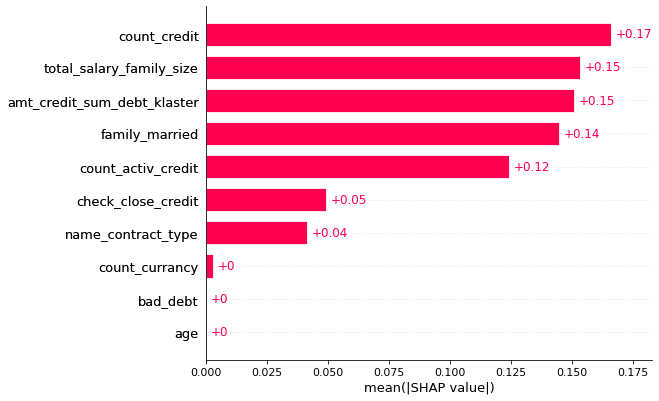

In [156]:
explainer = shap.Explainer(model_cb3)
shap_values = explainer(train)
shap.plots.bar(shap_values)

In [157]:
data = data.drop(["count_currancy"], 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [158]:
train, test, target, test_id = train_split(data)

In [159]:
model_cb4 = cb.CatBoostClassifier()
cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model_cb4, metric=roc_auc_score, cv_strategy=cv_strategy
)

(1334, 9) 1334
Learning rate set to 0.010592
0:	learn: 0.6895025	total: 3.1ms	remaining: 3.1s
1:	learn: 0.6857897	total: 6.21ms	remaining: 3.1s
2:	learn: 0.6821346	total: 8.71ms	remaining: 2.9s
3:	learn: 0.6788724	total: 10.5ms	remaining: 2.6s
4:	learn: 0.6755301	total: 12.9ms	remaining: 2.57s
5:	learn: 0.6723403	total: 16ms	remaining: 2.65s
6:	learn: 0.6692416	total: 17.5ms	remaining: 2.48s
7:	learn: 0.6661851	total: 22ms	remaining: 2.73s
8:	learn: 0.6632279	total: 27.3ms	remaining: 3s
9:	learn: 0.6600850	total: 32.1ms	remaining: 3.18s
10:	learn: 0.6572553	total: 35.8ms	remaining: 3.22s
11:	learn: 0.6544813	total: 38.9ms	remaining: 3.2s
12:	learn: 0.6515908	total: 42ms	remaining: 3.19s
13:	learn: 0.6486670	total: 45.1ms	remaining: 3.17s
14:	learn: 0.6459400	total: 48.1ms	remaining: 3.16s
15:	learn: 0.6434459	total: 50.2ms	remaining: 3.09s
16:	learn: 0.6407381	total: 53.2ms	remaining: 3.08s
17:	learn: 0.6380307	total: 56.1ms	remaining: 3.06s
18:	learn: 0.6354590	total: 59ms	remaining: 

193:	learn: 0.4989305	total: 316ms	remaining: 1.31s
194:	learn: 0.4986536	total: 318ms	remaining: 1.31s
195:	learn: 0.4986099	total: 319ms	remaining: 1.31s
196:	learn: 0.4984420	total: 320ms	remaining: 1.3s
197:	learn: 0.4983063	total: 322ms	remaining: 1.3s
198:	learn: 0.4981761	total: 323ms	remaining: 1.3s
199:	learn: 0.4979555	total: 325ms	remaining: 1.3s
200:	learn: 0.4979093	total: 326ms	remaining: 1.29s
201:	learn: 0.4978303	total: 327ms	remaining: 1.29s
202:	learn: 0.4976694	total: 329ms	remaining: 1.29s
203:	learn: 0.4974112	total: 331ms	remaining: 1.29s
204:	learn: 0.4972065	total: 332ms	remaining: 1.29s
205:	learn: 0.4970590	total: 334ms	remaining: 1.29s
206:	learn: 0.4968302	total: 336ms	remaining: 1.29s
207:	learn: 0.4967204	total: 337ms	remaining: 1.28s
208:	learn: 0.4963822	total: 339ms	remaining: 1.28s
209:	learn: 0.4959640	total: 340ms	remaining: 1.28s
210:	learn: 0.4956320	total: 341ms	remaining: 1.28s
211:	learn: 0.4952991	total: 343ms	remaining: 1.27s
212:	learn: 0.49

427:	learn: 0.4543380	total: 655ms	remaining: 876ms
428:	learn: 0.4541857	total: 657ms	remaining: 875ms
429:	learn: 0.4540346	total: 659ms	remaining: 874ms
430:	learn: 0.4539288	total: 661ms	remaining: 872ms
431:	learn: 0.4538454	total: 662ms	remaining: 871ms
432:	learn: 0.4537391	total: 664ms	remaining: 869ms
433:	learn: 0.4535368	total: 666ms	remaining: 868ms
434:	learn: 0.4535356	total: 667ms	remaining: 866ms
435:	learn: 0.4534332	total: 668ms	remaining: 865ms
436:	learn: 0.4530884	total: 670ms	remaining: 863ms
437:	learn: 0.4529601	total: 671ms	remaining: 861ms
438:	learn: 0.4527834	total: 672ms	remaining: 859ms
439:	learn: 0.4526397	total: 674ms	remaining: 857ms
440:	learn: 0.4525288	total: 675ms	remaining: 856ms
441:	learn: 0.4525262	total: 676ms	remaining: 853ms
442:	learn: 0.4523567	total: 677ms	remaining: 851ms
443:	learn: 0.4523068	total: 678ms	remaining: 850ms
444:	learn: 0.4520363	total: 680ms	remaining: 848ms
445:	learn: 0.4517142	total: 681ms	remaining: 846ms
446:	learn: 

675:	learn: 0.4165130	total: 998ms	remaining: 478ms
676:	learn: 0.4163756	total: 999ms	remaining: 477ms
677:	learn: 0.4161988	total: 1s	remaining: 475ms
678:	learn: 0.4160697	total: 1s	remaining: 474ms
679:	learn: 0.4158935	total: 1s	remaining: 472ms
680:	learn: 0.4157477	total: 1s	remaining: 471ms
681:	learn: 0.4156913	total: 1.01s	remaining: 469ms
682:	learn: 0.4155588	total: 1.01s	remaining: 468ms
683:	learn: 0.4154429	total: 1.01s	remaining: 466ms
684:	learn: 0.4153894	total: 1.01s	remaining: 464ms
685:	learn: 0.4152667	total: 1.01s	remaining: 463ms
686:	learn: 0.4149950	total: 1.01s	remaining: 461ms
687:	learn: 0.4147732	total: 1.01s	remaining: 460ms
688:	learn: 0.4147043	total: 1.01s	remaining: 458ms
689:	learn: 0.4145705	total: 1.02s	remaining: 457ms
690:	learn: 0.4145674	total: 1.02s	remaining: 455ms
691:	learn: 0.4144546	total: 1.02s	remaining: 453ms
692:	learn: 0.4142405	total: 1.02s	remaining: 452ms
693:	learn: 0.4141250	total: 1.02s	remaining: 450ms
694:	learn: 0.4140556	to

938:	learn: 0.3786239	total: 1.35s	remaining: 87.5ms
939:	learn: 0.3786146	total: 1.35s	remaining: 86.1ms
940:	learn: 0.3785049	total: 1.35s	remaining: 84.6ms
941:	learn: 0.3784225	total: 1.35s	remaining: 83.2ms
942:	learn: 0.3783169	total: 1.35s	remaining: 81.7ms
943:	learn: 0.3781775	total: 1.35s	remaining: 80.3ms
944:	learn: 0.3779969	total: 1.35s	remaining: 78.8ms
945:	learn: 0.3779872	total: 1.36s	remaining: 77.4ms
946:	learn: 0.3779783	total: 1.36s	remaining: 76ms
947:	learn: 0.3778892	total: 1.36s	remaining: 74.5ms
948:	learn: 0.3776571	total: 1.36s	remaining: 73.1ms
949:	learn: 0.3773494	total: 1.36s	remaining: 71.7ms
950:	learn: 0.3771230	total: 1.36s	remaining: 70.2ms
951:	learn: 0.3769920	total: 1.36s	remaining: 68.8ms
952:	learn: 0.3768754	total: 1.36s	remaining: 67.3ms
953:	learn: 0.3768204	total: 1.37s	remaining: 65.9ms
954:	learn: 0.3767409	total: 1.37s	remaining: 64.5ms
955:	learn: 0.3767008	total: 1.37s	remaining: 63ms
956:	learn: 0.3765754	total: 1.37s	remaining: 61.6

187:	learn: 0.4975449	total: 239ms	remaining: 1.03s
188:	learn: 0.4971979	total: 240ms	remaining: 1.03s
189:	learn: 0.4966275	total: 241ms	remaining: 1.03s
190:	learn: 0.4964576	total: 243ms	remaining: 1.03s
191:	learn: 0.4960997	total: 244ms	remaining: 1.03s
192:	learn: 0.4957629	total: 245ms	remaining: 1.02s
193:	learn: 0.4955980	total: 247ms	remaining: 1.02s
194:	learn: 0.4953348	total: 248ms	remaining: 1.02s
195:	learn: 0.4950941	total: 249ms	remaining: 1.02s
196:	learn: 0.4948702	total: 251ms	remaining: 1.02s
197:	learn: 0.4945482	total: 252ms	remaining: 1.02s
198:	learn: 0.4942027	total: 253ms	remaining: 1.02s
199:	learn: 0.4939816	total: 254ms	remaining: 1.02s
200:	learn: 0.4938942	total: 255ms	remaining: 1.01s
201:	learn: 0.4936323	total: 257ms	remaining: 1.01s
202:	learn: 0.4933573	total: 258ms	remaining: 1.01s
203:	learn: 0.4930342	total: 259ms	remaining: 1.01s
204:	learn: 0.4928491	total: 261ms	remaining: 1.01s
205:	learn: 0.4924723	total: 262ms	remaining: 1.01s
206:	learn: 

457:	learn: 0.4455132	total: 587ms	remaining: 695ms
458:	learn: 0.4453855	total: 589ms	remaining: 694ms
459:	learn: 0.4451836	total: 590ms	remaining: 693ms
460:	learn: 0.4450250	total: 591ms	remaining: 691ms
461:	learn: 0.4448855	total: 593ms	remaining: 690ms
462:	learn: 0.4447876	total: 594ms	remaining: 689ms
463:	learn: 0.4445244	total: 595ms	remaining: 688ms
464:	learn: 0.4442787	total: 596ms	remaining: 686ms
465:	learn: 0.4439894	total: 598ms	remaining: 685ms
466:	learn: 0.4437425	total: 599ms	remaining: 684ms
467:	learn: 0.4436153	total: 600ms	remaining: 682ms
468:	learn: 0.4433245	total: 602ms	remaining: 681ms
469:	learn: 0.4429308	total: 603ms	remaining: 680ms
470:	learn: 0.4428612	total: 604ms	remaining: 679ms
471:	learn: 0.4426776	total: 606ms	remaining: 677ms
472:	learn: 0.4423912	total: 607ms	remaining: 676ms
473:	learn: 0.4421049	total: 608ms	remaining: 675ms
474:	learn: 0.4419358	total: 609ms	remaining: 674ms
475:	learn: 0.4417838	total: 611ms	remaining: 672ms
476:	learn: 

723:	learn: 0.4033348	total: 937ms	remaining: 357ms
724:	learn: 0.4032286	total: 938ms	remaining: 356ms
725:	learn: 0.4030629	total: 940ms	remaining: 355ms
726:	learn: 0.4028720	total: 941ms	remaining: 353ms
727:	learn: 0.4027761	total: 942ms	remaining: 352ms
728:	learn: 0.4026150	total: 944ms	remaining: 351ms
729:	learn: 0.4024397	total: 945ms	remaining: 350ms
730:	learn: 0.4023640	total: 947ms	remaining: 348ms
731:	learn: 0.4022406	total: 948ms	remaining: 347ms
732:	learn: 0.4021504	total: 949ms	remaining: 346ms
733:	learn: 0.4019821	total: 950ms	remaining: 344ms
734:	learn: 0.4019029	total: 952ms	remaining: 343ms
735:	learn: 0.4017506	total: 953ms	remaining: 342ms
736:	learn: 0.4016074	total: 954ms	remaining: 341ms
737:	learn: 0.4014882	total: 956ms	remaining: 339ms
738:	learn: 0.4014765	total: 957ms	remaining: 338ms
739:	learn: 0.4013446	total: 959ms	remaining: 337ms
740:	learn: 0.4010418	total: 960ms	remaining: 336ms
741:	learn: 0.4009098	total: 961ms	remaining: 334ms
742:	learn: 

984:	learn: 0.3649963	total: 1.28s	remaining: 19.6ms
985:	learn: 0.3647906	total: 1.29s	remaining: 18.3ms
986:	learn: 0.3647232	total: 1.29s	remaining: 17ms
987:	learn: 0.3645391	total: 1.29s	remaining: 15.7ms
988:	learn: 0.3644842	total: 1.29s	remaining: 14.4ms
989:	learn: 0.3643614	total: 1.29s	remaining: 13.1ms
990:	learn: 0.3641347	total: 1.29s	remaining: 11.7ms
991:	learn: 0.3640694	total: 1.29s	remaining: 10.4ms
992:	learn: 0.3638809	total: 1.3s	remaining: 9.14ms
993:	learn: 0.3638667	total: 1.3s	remaining: 7.83ms
994:	learn: 0.3638170	total: 1.3s	remaining: 6.53ms
995:	learn: 0.3634757	total: 1.3s	remaining: 5.22ms
996:	learn: 0.3632749	total: 1.3s	remaining: 3.92ms
997:	learn: 0.3631016	total: 1.3s	remaining: 2.61ms
998:	learn: 0.3630425	total: 1.3s	remaining: 1.3ms
999:	learn: 0.3628823	total: 1.3s	remaining: 0us
Fold: 2, train-observations = 1067, valid-observations = 267
train-score = 0.6428, valid-score = 0.49
Learning rate set to 0.010592
0:	learn: 0.6892858	total: 1.4ms	r

229:	learn: 0.4746723	total: 296ms	remaining: 992ms
230:	learn: 0.4743324	total: 298ms	remaining: 992ms
231:	learn: 0.4740881	total: 299ms	remaining: 991ms
232:	learn: 0.4739768	total: 301ms	remaining: 990ms
233:	learn: 0.4736521	total: 302ms	remaining: 988ms
234:	learn: 0.4734714	total: 303ms	remaining: 987ms
235:	learn: 0.4729618	total: 305ms	remaining: 986ms
236:	learn: 0.4727436	total: 306ms	remaining: 985ms
237:	learn: 0.4722818	total: 307ms	remaining: 983ms
238:	learn: 0.4720625	total: 308ms	remaining: 982ms
239:	learn: 0.4718156	total: 310ms	remaining: 981ms
240:	learn: 0.4717649	total: 311ms	remaining: 979ms
241:	learn: 0.4712178	total: 312ms	remaining: 978ms
242:	learn: 0.4708125	total: 314ms	remaining: 977ms
243:	learn: 0.4707236	total: 315ms	remaining: 976ms
244:	learn: 0.4705177	total: 316ms	remaining: 975ms
245:	learn: 0.4703076	total: 318ms	remaining: 974ms
246:	learn: 0.4701098	total: 319ms	remaining: 972ms
247:	learn: 0.4700047	total: 320ms	remaining: 971ms
248:	learn: 

495:	learn: 0.4255571	total: 644ms	remaining: 654ms
496:	learn: 0.4254423	total: 645ms	remaining: 653ms
497:	learn: 0.4252171	total: 647ms	remaining: 652ms
498:	learn: 0.4250706	total: 648ms	remaining: 651ms
499:	learn: 0.4249380	total: 650ms	remaining: 650ms
500:	learn: 0.4247505	total: 651ms	remaining: 648ms
501:	learn: 0.4245902	total: 652ms	remaining: 647ms
502:	learn: 0.4244314	total: 654ms	remaining: 646ms
503:	learn: 0.4241838	total: 655ms	remaining: 645ms
504:	learn: 0.4239985	total: 656ms	remaining: 643ms
505:	learn: 0.4238736	total: 658ms	remaining: 642ms
506:	learn: 0.4236926	total: 659ms	remaining: 641ms
507:	learn: 0.4235686	total: 660ms	remaining: 639ms
508:	learn: 0.4234451	total: 662ms	remaining: 638ms
509:	learn: 0.4232041	total: 663ms	remaining: 637ms
510:	learn: 0.4229433	total: 664ms	remaining: 636ms
511:	learn: 0.4228406	total: 666ms	remaining: 634ms
512:	learn: 0.4226265	total: 667ms	remaining: 633ms
513:	learn: 0.4224465	total: 668ms	remaining: 632ms
514:	learn: 

749:	learn: 0.3882579	total: 992ms	remaining: 331ms
750:	learn: 0.3880651	total: 994ms	remaining: 330ms
751:	learn: 0.3878558	total: 995ms	remaining: 328ms
752:	learn: 0.3877670	total: 996ms	remaining: 327ms
753:	learn: 0.3876486	total: 998ms	remaining: 326ms
754:	learn: 0.3874454	total: 999ms	remaining: 324ms
755:	learn: 0.3871938	total: 1s	remaining: 323ms
756:	learn: 0.3871618	total: 1s	remaining: 322ms
757:	learn: 0.3870135	total: 1s	remaining: 320ms
758:	learn: 0.3867279	total: 1s	remaining: 319ms
759:	learn: 0.3866266	total: 1s	remaining: 318ms
760:	learn: 0.3864718	total: 1.01s	remaining: 316ms
761:	learn: 0.3862981	total: 1.01s	remaining: 315ms
762:	learn: 0.3861806	total: 1.01s	remaining: 314ms
763:	learn: 0.3859615	total: 1.01s	remaining: 312ms
764:	learn: 0.3857728	total: 1.01s	remaining: 311ms
765:	learn: 0.3856116	total: 1.01s	remaining: 310ms
766:	learn: 0.3855251	total: 1.01s	remaining: 308ms
767:	learn: 0.3854006	total: 1.02s	remaining: 307ms
768:	learn: 0.3852750	total

Learning rate set to 0.010592
0:	learn: 0.6896407	total: 1.62ms	remaining: 1.62s
1:	learn: 0.6860416	total: 2.88ms	remaining: 1.44s
2:	learn: 0.6823400	total: 4.13ms	remaining: 1.37s
3:	learn: 0.6789763	total: 5.39ms	remaining: 1.34s
4:	learn: 0.6757424	total: 6.66ms	remaining: 1.33s
5:	learn: 0.6726673	total: 7.76ms	remaining: 1.29s
6:	learn: 0.6693742	total: 9.07ms	remaining: 1.29s
7:	learn: 0.6664379	total: 10.1ms	remaining: 1.25s
8:	learn: 0.6634272	total: 11.4ms	remaining: 1.25s
9:	learn: 0.6598635	total: 12.7ms	remaining: 1.25s
10:	learn: 0.6567524	total: 14ms	remaining: 1.26s
11:	learn: 0.6539774	total: 15.3ms	remaining: 1.26s
12:	learn: 0.6511735	total: 16.7ms	remaining: 1.26s
13:	learn: 0.6485035	total: 17.9ms	remaining: 1.26s
14:	learn: 0.6459883	total: 19.2ms	remaining: 1.26s
15:	learn: 0.6431938	total: 20.5ms	remaining: 1.26s
16:	learn: 0.6404714	total: 21.8ms	remaining: 1.26s
17:	learn: 0.6380843	total: 23.1ms	remaining: 1.26s
18:	learn: 0.6354205	total: 24.5ms	remaining: 

259:	learn: 0.4830105	total: 343ms	remaining: 976ms
260:	learn: 0.4829029	total: 344ms	remaining: 974ms
261:	learn: 0.4827557	total: 345ms	remaining: 973ms
262:	learn: 0.4824066	total: 347ms	remaining: 972ms
263:	learn: 0.4821697	total: 348ms	remaining: 971ms
264:	learn: 0.4819942	total: 350ms	remaining: 970ms
265:	learn: 0.4818897	total: 351ms	remaining: 968ms
266:	learn: 0.4816467	total: 352ms	remaining: 967ms
267:	learn: 0.4814281	total: 354ms	remaining: 966ms
268:	learn: 0.4811640	total: 355ms	remaining: 965ms
269:	learn: 0.4809754	total: 356ms	remaining: 963ms
270:	learn: 0.4807011	total: 358ms	remaining: 962ms
271:	learn: 0.4805764	total: 359ms	remaining: 960ms
272:	learn: 0.4803357	total: 360ms	remaining: 959ms
273:	learn: 0.4801238	total: 362ms	remaining: 958ms
274:	learn: 0.4798276	total: 363ms	remaining: 958ms
275:	learn: 0.4794552	total: 365ms	remaining: 957ms
276:	learn: 0.4792587	total: 366ms	remaining: 956ms
277:	learn: 0.4790885	total: 368ms	remaining: 955ms
278:	learn: 

520:	learn: 0.4385740	total: 689ms	remaining: 634ms
521:	learn: 0.4384028	total: 691ms	remaining: 633ms
522:	learn: 0.4382714	total: 692ms	remaining: 631ms
523:	learn: 0.4381076	total: 694ms	remaining: 630ms
524:	learn: 0.4379485	total: 695ms	remaining: 629ms
525:	learn: 0.4376840	total: 696ms	remaining: 628ms
526:	learn: 0.4376641	total: 697ms	remaining: 626ms
527:	learn: 0.4375856	total: 699ms	remaining: 624ms
528:	learn: 0.4374859	total: 700ms	remaining: 623ms
529:	learn: 0.4373507	total: 701ms	remaining: 622ms
530:	learn: 0.4371583	total: 703ms	remaining: 621ms
531:	learn: 0.4370677	total: 704ms	remaining: 619ms
532:	learn: 0.4367257	total: 705ms	remaining: 618ms
533:	learn: 0.4365564	total: 707ms	remaining: 617ms
534:	learn: 0.4364453	total: 708ms	remaining: 615ms
535:	learn: 0.4362535	total: 709ms	remaining: 614ms
536:	learn: 0.4361566	total: 711ms	remaining: 613ms
537:	learn: 0.4359685	total: 712ms	remaining: 611ms
538:	learn: 0.4359254	total: 713ms	remaining: 610ms
539:	learn: 

782:	learn: 0.4001751	total: 1.04s	remaining: 287ms
783:	learn: 0.4000035	total: 1.04s	remaining: 286ms
784:	learn: 0.3997902	total: 1.04s	remaining: 285ms
785:	learn: 0.3996411	total: 1.04s	remaining: 283ms
786:	learn: 0.3994551	total: 1.04s	remaining: 282ms
787:	learn: 0.3993531	total: 1.04s	remaining: 281ms
788:	learn: 0.3991708	total: 1.05s	remaining: 280ms
789:	learn: 0.3989261	total: 1.05s	remaining: 279ms
790:	learn: 0.3986972	total: 1.05s	remaining: 277ms
791:	learn: 0.3985708	total: 1.05s	remaining: 276ms
792:	learn: 0.3984062	total: 1.05s	remaining: 275ms
793:	learn: 0.3982563	total: 1.05s	remaining: 273ms
794:	learn: 0.3981344	total: 1.05s	remaining: 272ms
795:	learn: 0.3979250	total: 1.06s	remaining: 271ms
796:	learn: 0.3975341	total: 1.06s	remaining: 270ms
797:	learn: 0.3973514	total: 1.06s	remaining: 268ms
798:	learn: 0.3971370	total: 1.06s	remaining: 267ms
799:	learn: 0.3969565	total: 1.06s	remaining: 266ms
800:	learn: 0.3968455	total: 1.06s	remaining: 264ms
801:	learn: 

19:	learn: 0.6253594	total: 26.1ms	remaining: 1.28s
20:	learn: 0.6225784	total: 27.7ms	remaining: 1.29s
21:	learn: 0.6200253	total: 29ms	remaining: 1.29s
22:	learn: 0.6175758	total: 30.2ms	remaining: 1.28s
23:	learn: 0.6151165	total: 31.5ms	remaining: 1.28s
24:	learn: 0.6124500	total: 32.8ms	remaining: 1.28s
25:	learn: 0.6099795	total: 34.2ms	remaining: 1.28s
26:	learn: 0.6076283	total: 35.5ms	remaining: 1.28s
27:	learn: 0.6054156	total: 36.7ms	remaining: 1.27s
28:	learn: 0.6033504	total: 37.6ms	remaining: 1.26s
29:	learn: 0.6013574	total: 38.3ms	remaining: 1.24s
30:	learn: 0.5992881	total: 39.6ms	remaining: 1.24s
31:	learn: 0.5970266	total: 40.9ms	remaining: 1.24s
32:	learn: 0.5949777	total: 42.2ms	remaining: 1.24s
33:	learn: 0.5927824	total: 43.5ms	remaining: 1.24s
34:	learn: 0.5908540	total: 44.9ms	remaining: 1.24s
35:	learn: 0.5889482	total: 46.2ms	remaining: 1.24s
36:	learn: 0.5869200	total: 47.5ms	remaining: 1.24s
37:	learn: 0.5851519	total: 48.8ms	remaining: 1.23s
38:	learn: 0.5

295:	learn: 0.4633570	total: 375ms	remaining: 892ms
296:	learn: 0.4632762	total: 377ms	remaining: 892ms
297:	learn: 0.4631385	total: 378ms	remaining: 890ms
298:	learn: 0.4629294	total: 379ms	remaining: 889ms
299:	learn: 0.4627878	total: 381ms	remaining: 888ms
300:	learn: 0.4626568	total: 382ms	remaining: 887ms
301:	learn: 0.4623499	total: 383ms	remaining: 886ms
302:	learn: 0.4622035	total: 385ms	remaining: 885ms
303:	learn: 0.4621134	total: 386ms	remaining: 883ms
304:	learn: 0.4618540	total: 387ms	remaining: 882ms
305:	learn: 0.4617769	total: 388ms	remaining: 881ms
306:	learn: 0.4615683	total: 390ms	remaining: 880ms
307:	learn: 0.4614438	total: 391ms	remaining: 878ms
308:	learn: 0.4613451	total: 392ms	remaining: 877ms
309:	learn: 0.4610910	total: 393ms	remaining: 876ms
310:	learn: 0.4609700	total: 395ms	remaining: 875ms
311:	learn: 0.4607171	total: 396ms	remaining: 873ms
312:	learn: 0.4605436	total: 397ms	remaining: 872ms
313:	learn: 0.4603834	total: 399ms	remaining: 871ms
314:	learn: 

567:	learn: 0.4217964	total: 724ms	remaining: 551ms
568:	learn: 0.4216224	total: 726ms	remaining: 550ms
569:	learn: 0.4213915	total: 727ms	remaining: 549ms
570:	learn: 0.4211596	total: 729ms	remaining: 548ms
571:	learn: 0.4210235	total: 730ms	remaining: 546ms
572:	learn: 0.4209453	total: 731ms	remaining: 545ms
573:	learn: 0.4208462	total: 733ms	remaining: 544ms
574:	learn: 0.4206065	total: 734ms	remaining: 543ms
575:	learn: 0.4205189	total: 735ms	remaining: 541ms
576:	learn: 0.4203076	total: 737ms	remaining: 540ms
577:	learn: 0.4202161	total: 738ms	remaining: 539ms
578:	learn: 0.4200432	total: 739ms	remaining: 538ms
579:	learn: 0.4199798	total: 741ms	remaining: 536ms
580:	learn: 0.4197101	total: 742ms	remaining: 535ms
581:	learn: 0.4195727	total: 743ms	remaining: 534ms
582:	learn: 0.4194181	total: 745ms	remaining: 533ms
583:	learn: 0.4192898	total: 746ms	remaining: 531ms
584:	learn: 0.4191950	total: 747ms	remaining: 530ms
585:	learn: 0.4190632	total: 749ms	remaining: 529ms
586:	learn: 

833:	learn: 0.3819108	total: 1.07s	remaining: 214ms
834:	learn: 0.3817766	total: 1.07s	remaining: 212ms
835:	learn: 0.3815260	total: 1.07s	remaining: 211ms
836:	learn: 0.3814220	total: 1.08s	remaining: 210ms
837:	learn: 0.3813621	total: 1.08s	remaining: 208ms
838:	learn: 0.3812993	total: 1.08s	remaining: 207ms
839:	learn: 0.3810989	total: 1.08s	remaining: 206ms
840:	learn: 0.3810232	total: 1.08s	remaining: 205ms
841:	learn: 0.3808894	total: 1.08s	remaining: 203ms
842:	learn: 0.3807650	total: 1.08s	remaining: 202ms
843:	learn: 0.3806503	total: 1.09s	remaining: 201ms
844:	learn: 0.3804565	total: 1.09s	remaining: 199ms
845:	learn: 0.3802648	total: 1.09s	remaining: 198ms
846:	learn: 0.3801231	total: 1.09s	remaining: 197ms
847:	learn: 0.3799621	total: 1.09s	remaining: 196ms
848:	learn: 0.3798764	total: 1.09s	remaining: 194ms
849:	learn: 0.3798719	total: 1.09s	remaining: 193ms
850:	learn: 0.3797383	total: 1.09s	remaining: 192ms
851:	learn: 0.3796108	total: 1.1s	remaining: 190ms
852:	learn: 0

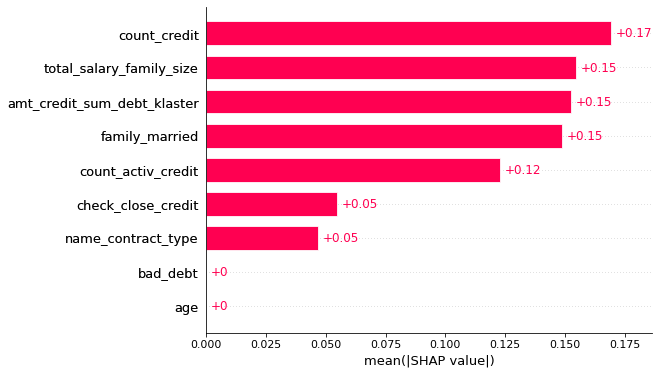

In [160]:
explainer = shap.Explainer(model_cb4)
shap_values = explainer(train)
shap.plots.bar(shap_values)

In [161]:
data = data.drop("bad_debt", 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


(9536, 8) 9536
0:	total: 3.82ms	remaining: 7.64s
10:	total: 30.9ms	remaining: 5.59s
20:	total: 53.3ms	remaining: 5.02s
30:	total: 73.5ms	remaining: 4.67s
40:	total: 93.9ms	remaining: 4.49s
50:	total: 115ms	remaining: 4.4s
60:	total: 136ms	remaining: 4.33s
70:	total: 157ms	remaining: 4.27s
80:	total: 176ms	remaining: 4.18s
90:	total: 195ms	remaining: 4.1s
100:	total: 214ms	remaining: 4.02s
110:	total: 232ms	remaining: 3.94s
120:	total: 250ms	remaining: 3.88s
130:	total: 268ms	remaining: 3.82s
140:	total: 287ms	remaining: 3.79s
150:	total: 305ms	remaining: 3.74s
160:	total: 323ms	remaining: 3.69s
170:	total: 341ms	remaining: 3.64s
180:	total: 358ms	remaining: 3.6s
190:	total: 377ms	remaining: 3.57s
200:	total: 396ms	remaining: 3.54s
210:	total: 415ms	remaining: 3.52s
220:	total: 433ms	remaining: 3.48s
230:	total: 452ms	remaining: 3.46s
240:	total: 471ms	remaining: 3.44s
250:	total: 489ms	remaining: 3.41s
260:	total: 508ms	remaining: 3.39s
270:	total: 528ms	remaining: 3.37s
280:	total: 54

270:	total: 478ms	remaining: 3.05s
280:	total: 495ms	remaining: 3.03s
290:	total: 513ms	remaining: 3.01s
300:	total: 530ms	remaining: 2.99s
310:	total: 548ms	remaining: 2.98s
320:	total: 566ms	remaining: 2.96s
330:	total: 584ms	remaining: 2.94s
340:	total: 602ms	remaining: 2.93s
350:	total: 620ms	remaining: 2.91s
360:	total: 638ms	remaining: 2.9s
370:	total: 657ms	remaining: 2.88s
380:	total: 676ms	remaining: 2.87s
390:	total: 694ms	remaining: 2.85s
400:	total: 713ms	remaining: 2.84s
410:	total: 730ms	remaining: 2.82s
420:	total: 750ms	remaining: 2.81s
430:	total: 770ms	remaining: 2.8s
440:	total: 798ms	remaining: 2.82s
450:	total: 820ms	remaining: 2.81s
460:	total: 840ms	remaining: 2.8s
470:	total: 860ms	remaining: 2.79s
480:	total: 880ms	remaining: 2.78s
490:	total: 900ms	remaining: 2.77s
500:	total: 920ms	remaining: 2.75s
510:	total: 940ms	remaining: 2.74s
520:	total: 960ms	remaining: 2.72s
530:	total: 980ms	remaining: 2.71s
540:	total: 1s	remaining: 2.7s
550:	total: 1.02s	remaining

640:	total: 1.16s	remaining: 2.46s
650:	total: 1.18s	remaining: 2.45s
660:	total: 1.2s	remaining: 2.43s
670:	total: 1.22s	remaining: 2.41s
680:	total: 1.24s	remaining: 2.39s
690:	total: 1.25s	remaining: 2.38s
700:	total: 1.27s	remaining: 2.35s
710:	total: 1.29s	remaining: 2.34s
720:	total: 1.3s	remaining: 2.31s
730:	total: 1.32s	remaining: 2.3s
740:	total: 1.34s	remaining: 2.28s
750:	total: 1.36s	remaining: 2.26s
760:	total: 1.38s	remaining: 2.24s
770:	total: 1.4s	remaining: 2.22s
780:	total: 1.41s	remaining: 2.21s
790:	total: 1.43s	remaining: 2.19s
800:	total: 1.45s	remaining: 2.17s
810:	total: 1.47s	remaining: 2.15s
820:	total: 1.49s	remaining: 2.13s
830:	total: 1.5s	remaining: 2.12s
840:	total: 1.52s	remaining: 2.1s
850:	total: 1.54s	remaining: 2.08s
860:	total: 1.56s	remaining: 2.06s
870:	total: 1.58s	remaining: 2.05s
880:	total: 1.6s	remaining: 2.03s
890:	total: 1.61s	remaining: 2.01s
900:	total: 1.63s	remaining: 1.99s
910:	total: 1.65s	remaining: 1.97s
920:	total: 1.67s	remaining

930:	total: 1.68s	remaining: 1.93s
940:	total: 1.7s	remaining: 1.91s
950:	total: 1.72s	remaining: 1.9s
960:	total: 1.74s	remaining: 1.88s
970:	total: 1.76s	remaining: 1.86s
980:	total: 1.77s	remaining: 1.84s
990:	total: 1.79s	remaining: 1.83s
1000:	total: 1.81s	remaining: 1.81s
1010:	total: 1.83s	remaining: 1.79s
1020:	total: 1.85s	remaining: 1.77s
1030:	total: 1.87s	remaining: 1.76s
1040:	total: 1.89s	remaining: 1.74s
1050:	total: 1.91s	remaining: 1.72s
1060:	total: 1.93s	remaining: 1.7s
1070:	total: 1.94s	remaining: 1.69s
1080:	total: 1.96s	remaining: 1.67s
1090:	total: 1.98s	remaining: 1.65s
1100:	total: 2s	remaining: 1.63s
1110:	total: 2.02s	remaining: 1.61s
1120:	total: 2.03s	remaining: 1.59s
1130:	total: 2.05s	remaining: 1.57s
1140:	total: 2.07s	remaining: 1.56s
1150:	total: 2.08s	remaining: 1.54s
1160:	total: 2.1s	remaining: 1.52s
1170:	total: 2.12s	remaining: 1.5s
1180:	total: 2.14s	remaining: 1.48s
1190:	total: 2.16s	remaining: 1.47s
1200:	total: 2.17s	remaining: 1.45s
1210:	t

1190:	total: 2.12s	remaining: 1.44s
1200:	total: 2.14s	remaining: 1.42s
1210:	total: 2.16s	remaining: 1.41s
1220:	total: 2.18s	remaining: 1.39s
1230:	total: 2.2s	remaining: 1.37s
1240:	total: 2.21s	remaining: 1.35s
1250:	total: 2.23s	remaining: 1.34s
1260:	total: 2.25s	remaining: 1.32s
1270:	total: 2.27s	remaining: 1.3s
1280:	total: 2.29s	remaining: 1.29s
1290:	total: 2.31s	remaining: 1.27s
1300:	total: 2.33s	remaining: 1.25s
1310:	total: 2.35s	remaining: 1.23s
1320:	total: 2.37s	remaining: 1.22s
1330:	total: 2.38s	remaining: 1.2s
1340:	total: 2.4s	remaining: 1.18s
1350:	total: 2.42s	remaining: 1.16s
1360:	total: 2.44s	remaining: 1.15s
1370:	total: 2.46s	remaining: 1.13s
1380:	total: 2.48s	remaining: 1.11s
1390:	total: 2.49s	remaining: 1.09s
1400:	total: 2.51s	remaining: 1.07s
1410:	total: 2.53s	remaining: 1.06s
1420:	total: 2.55s	remaining: 1.04s
1430:	total: 2.57s	remaining: 1.02s
1440:	total: 2.59s	remaining: 1s
1450:	total: 2.6s	remaining: 986ms
1460:	total: 2.62s	remaining: 968ms


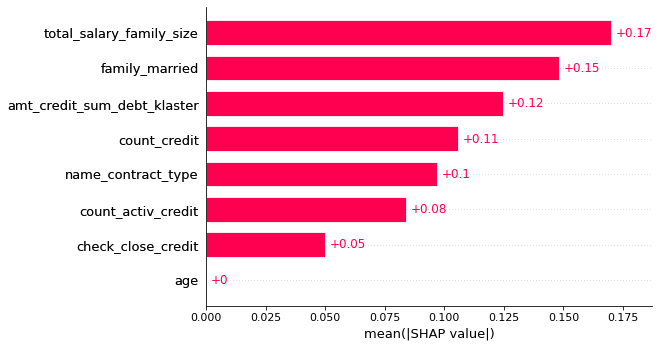

In [162]:
pipeline_train(data)

In [163]:
data = data.drop("age", 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


(9536, 7) 9536
0:	total: 2ms	remaining: 4s
10:	total: 19.1ms	remaining: 3.46s
20:	total: 38ms	remaining: 3.58s
30:	total: 57.6ms	remaining: 3.66s
40:	total: 78.7ms	remaining: 3.76s
50:	total: 98.5ms	remaining: 3.76s
60:	total: 119ms	remaining: 3.79s
70:	total: 139ms	remaining: 3.78s
80:	total: 159ms	remaining: 3.77s
90:	total: 180ms	remaining: 3.77s
100:	total: 204ms	remaining: 3.84s
110:	total: 226ms	remaining: 3.85s
120:	total: 246ms	remaining: 3.82s
130:	total: 267ms	remaining: 3.81s
140:	total: 291ms	remaining: 3.83s
150:	total: 311ms	remaining: 3.81s
160:	total: 332ms	remaining: 3.79s
170:	total: 352ms	remaining: 3.76s
180:	total: 371ms	remaining: 3.73s
190:	total: 393ms	remaining: 3.72s
200:	total: 414ms	remaining: 3.7s
210:	total: 438ms	remaining: 3.71s
220:	total: 461ms	remaining: 3.71s
230:	total: 481ms	remaining: 3.69s
240:	total: 501ms	remaining: 3.66s
250:	total: 523ms	remaining: 3.65s
260:	total: 544ms	remaining: 3.62s
270:	total: 564ms	remaining: 3.6s
280:	total: 583ms	re

330:	total: 633ms	remaining: 3.19s
340:	total: 652ms	remaining: 3.17s
350:	total: 671ms	remaining: 3.15s
360:	total: 690ms	remaining: 3.13s
370:	total: 709ms	remaining: 3.11s
380:	total: 728ms	remaining: 3.1s
390:	total: 747ms	remaining: 3.07s
400:	total: 766ms	remaining: 3.05s
410:	total: 784ms	remaining: 3.03s
420:	total: 803ms	remaining: 3.01s
430:	total: 824ms	remaining: 3s
440:	total: 842ms	remaining: 2.98s
450:	total: 860ms	remaining: 2.95s
460:	total: 878ms	remaining: 2.93s
470:	total: 896ms	remaining: 2.91s
480:	total: 915ms	remaining: 2.89s
490:	total: 933ms	remaining: 2.87s
500:	total: 953ms	remaining: 2.85s
510:	total: 972ms	remaining: 2.83s
520:	total: 990ms	remaining: 2.81s
530:	total: 1.01s	remaining: 2.79s
540:	total: 1.02s	remaining: 2.77s
550:	total: 1.04s	remaining: 2.74s
560:	total: 1.06s	remaining: 2.72s
570:	total: 1.08s	remaining: 2.7s
580:	total: 1.1s	remaining: 2.68s
590:	total: 1.11s	remaining: 2.66s
600:	total: 1.13s	remaining: 2.64s
610:	total: 1.15s	remainin

680:	total: 1.44s	remaining: 2.78s
690:	total: 1.46s	remaining: 2.76s
700:	total: 1.48s	remaining: 2.75s
710:	total: 1.5s	remaining: 2.72s
720:	total: 1.52s	remaining: 2.7s
730:	total: 1.54s	remaining: 2.68s
740:	total: 1.56s	remaining: 2.65s
750:	total: 1.58s	remaining: 2.63s
760:	total: 1.6s	remaining: 2.61s
770:	total: 1.62s	remaining: 2.59s
780:	total: 1.65s	remaining: 2.57s
790:	total: 1.67s	remaining: 2.55s
800:	total: 1.69s	remaining: 2.53s
810:	total: 1.72s	remaining: 2.52s
820:	total: 1.74s	remaining: 2.5s
830:	total: 1.77s	remaining: 2.48s
840:	total: 1.79s	remaining: 2.46s
850:	total: 1.8s	remaining: 2.44s
860:	total: 1.82s	remaining: 2.41s
870:	total: 1.84s	remaining: 2.39s
880:	total: 1.86s	remaining: 2.37s
890:	total: 1.88s	remaining: 2.35s
900:	total: 1.9s	remaining: 2.32s
910:	total: 1.92s	remaining: 2.3s
920:	total: 1.94s	remaining: 2.28s
930:	total: 1.96s	remaining: 2.25s
940:	total: 1.98s	remaining: 2.23s
950:	total: 2s	remaining: 2.21s
960:	total: 2.02s	remaining: 2

1000:	total: 1.93s	remaining: 1.93s
1010:	total: 1.95s	remaining: 1.91s
1020:	total: 1.97s	remaining: 1.89s
1030:	total: 1.99s	remaining: 1.87s
1040:	total: 2.01s	remaining: 1.85s
1050:	total: 2.03s	remaining: 1.83s
1060:	total: 2.05s	remaining: 1.81s
1070:	total: 2.07s	remaining: 1.79s
1080:	total: 2.09s	remaining: 1.77s
1090:	total: 2.11s	remaining: 1.76s
1100:	total: 2.13s	remaining: 1.74s
1110:	total: 2.15s	remaining: 1.72s
1120:	total: 2.17s	remaining: 1.7s
1130:	total: 2.19s	remaining: 1.68s
1140:	total: 2.21s	remaining: 1.67s
1150:	total: 2.23s	remaining: 1.65s
1160:	total: 2.25s	remaining: 1.63s
1170:	total: 2.27s	remaining: 1.61s
1180:	total: 2.29s	remaining: 1.59s
1190:	total: 2.31s	remaining: 1.57s
1200:	total: 2.33s	remaining: 1.55s
1210:	total: 2.35s	remaining: 1.53s
1220:	total: 2.38s	remaining: 1.51s
1230:	total: 2.4s	remaining: 1.5s
1240:	total: 2.41s	remaining: 1.48s
1250:	total: 2.43s	remaining: 1.46s
1260:	total: 2.45s	remaining: 1.44s
1270:	total: 2.47s	remaining: 1

1320:	total: 2.45s	remaining: 1.26s
1330:	total: 2.47s	remaining: 1.24s
1340:	total: 2.49s	remaining: 1.22s
1350:	total: 2.51s	remaining: 1.2s
1360:	total: 2.53s	remaining: 1.19s
1370:	total: 2.54s	remaining: 1.17s
1380:	total: 2.56s	remaining: 1.15s
1390:	total: 2.58s	remaining: 1.13s
1400:	total: 2.6s	remaining: 1.11s
1410:	total: 2.62s	remaining: 1.09s
1420:	total: 2.64s	remaining: 1.08s
1430:	total: 2.66s	remaining: 1.06s
1440:	total: 2.68s	remaining: 1.04s
1450:	total: 2.7s	remaining: 1.02s
1460:	total: 2.72s	remaining: 1s
1470:	total: 2.73s	remaining: 984ms
1480:	total: 2.75s	remaining: 965ms
1490:	total: 2.77s	remaining: 947ms
1500:	total: 2.79s	remaining: 928ms
1510:	total: 2.81s	remaining: 909ms
1520:	total: 2.83s	remaining: 891ms
1530:	total: 2.85s	remaining: 872ms
1540:	total: 2.87s	remaining: 854ms
1550:	total: 2.88s	remaining: 835ms
1560:	total: 2.9s	remaining: 817ms
1570:	total: 2.92s	remaining: 798ms
1580:	total: 2.94s	remaining: 779ms
1590:	total: 2.96s	remaining: 760ms

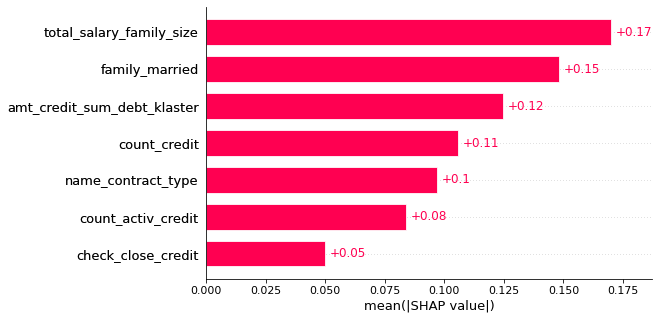

In [164]:
pipeline_train(data)